## Survival Analysis for Churn Prediction

References:
- [Understanding customer churn with survival analysis](https://www.prooveintelligence.com/blog/understanding-customer-churn-with-survival-analysis/)
- [Modeling Customer Churn With Survival Analysis](https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a)
- [Cox PH in R - Video](https://www.bing.com/videos/riverview/relatedvideo?q=what%20is%20proportianal%20hazard%20assumption&mid=457D299A5D2922681EFA457D299A5D2922681EFA&ajaxhist=0)
- [Checking Cox PH assumptions in R - Video](https://www.bing.com/videos/riverview/relatedvideo?q=what%20is%20proportianal%20hazard%20assumption&mid=D3CE2D85BB908022231AD3CE2D85BB908022231A&ajaxhist=0)
- [Survival Analysis - Text](https://www.bing.com/ck/a?!&&p=d2e7469f30623b96c301b6f41736b39971c8bbe9ab0ec8e2fa25cc0eac9133a6JmltdHM9MTczMzk2MTYwMA&ptn=3&ver=2&hsh=4&fclid=3cb063e7-f417-65ec-1670-773df540642f&psq=what+is+the+difference+between+kaplan+meier+and+cox+regressin&u=a1aHR0cHM6Ly9ib29rZG93bi5vcmcvZHJraV9tdXNhL2RhdGFhbmFseXNpcy9zdXJ2aXZhbC1hbmFseXNpcy1rYXBsYW4tbWVpZXItYW5kLWNveC1wcm9wb3J0aW9uYWwtaGF6YXJkLXBoLXJlZ3Jlc3Npb24uaHRtbA&ntb=1)

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=c19cef79c013e2f2c2ae98069d4cbcc827a4d11fefcfcaab1ea29270029cff3f
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sns
import statsmodels as stm
import lifelines
from sklearn.preprocessing import StandardScaler

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
churn_data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

churn_data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [ ]:
churn_data.shape

(7043, 21)

In [ ]:
# Converting Senior Citizen to object for EDA

churn_data['SeniorCitizen'] = churn_data['SeniorCitizen'].replace({1: 'Yes', 0: 'No'}).astype('object')

churn_data['SeniorCitizen'].value_counts()

SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64

In [ ]:
# Converting TotalCharges column to float from object

churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce').fillna(0)

In [ ]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [ ]:
data = churn_data.drop('customerID', axis=1)

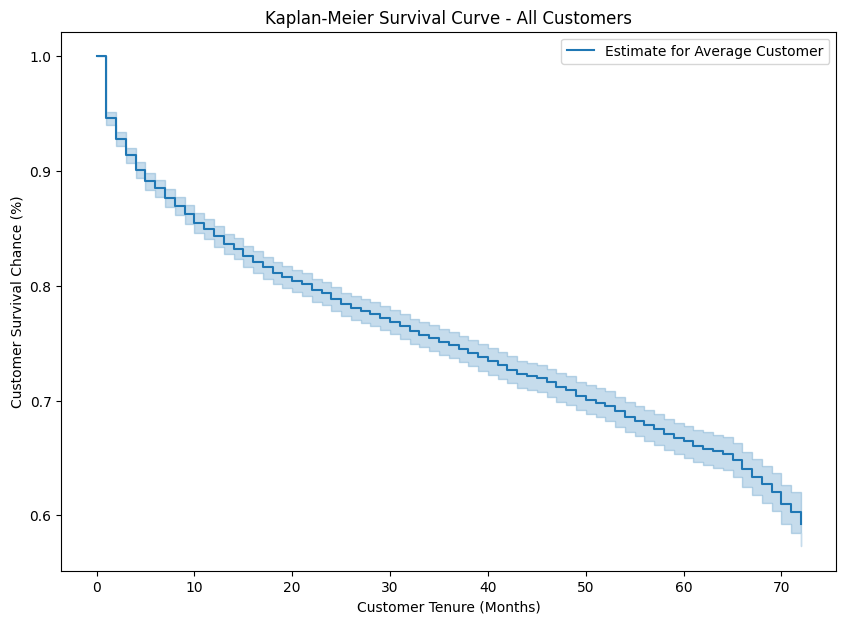

In [ ]:
# Convert 'Churn' column to numeric: 1 for 'Yes', 0 for 'No'
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# fitting kmf to churn data
t = data['tenure'].values
churn = data['Churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve - All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

- Churn is relatively low. Even after 72 months, the company is able to retain 60% or more of their customers.

- To examine the effects of different features, we will use the Cox Proportional Hazards Model. We can think of this as a Survival Regression model.

- 'Hazards' can be thought of something that would increase/decrease chances of survival. In our business problem, for example, a hazard may be the type of contract a customer has. Customers with multi-year contracts probably cancel less frequently than those with month-to-month contracts.

- One restriction is the model assumes a constant ratio of hazards over time across groups. Lifeline offers a built in check_assumptions method for the CoxPHFitter object.

In [ ]:
for col in data.columns:
  print(f"Unique values in column '{col}':")
  print(data[col].unique())
  print("-" * 20)

Unique values in column 'gender':
[0 1]
--------------------
Unique values in column 'SeniorCitizen':
[0 1]
--------------------
Unique values in column 'Partner':
[1 0]
--------------------
Unique values in column 'Dependents':
[0 1]
--------------------
Unique values in column 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
--------------------
Unique values in column 'PhoneService':
[0 1]
--------------------
Unique values in column 'MultipleLines':
[1 0 2]
--------------------
Unique values in column 'InternetService':
[0 1 2]
--------------------
Unique values in column 'OnlineSecurity':
[0 2 1]
--------------------
Unique values in column 'OnlineBackup':
[2 0 1]
--------------------
Unique values in column 'DeviceProtection':
[0 2 1]
--------------------
Unique values in column 'TechSupport':
[0 2

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Iterate through columns and apply Label Encoding to categorical features
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = le.fit_transform(data[col])

In [ ]:
data['Churn']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

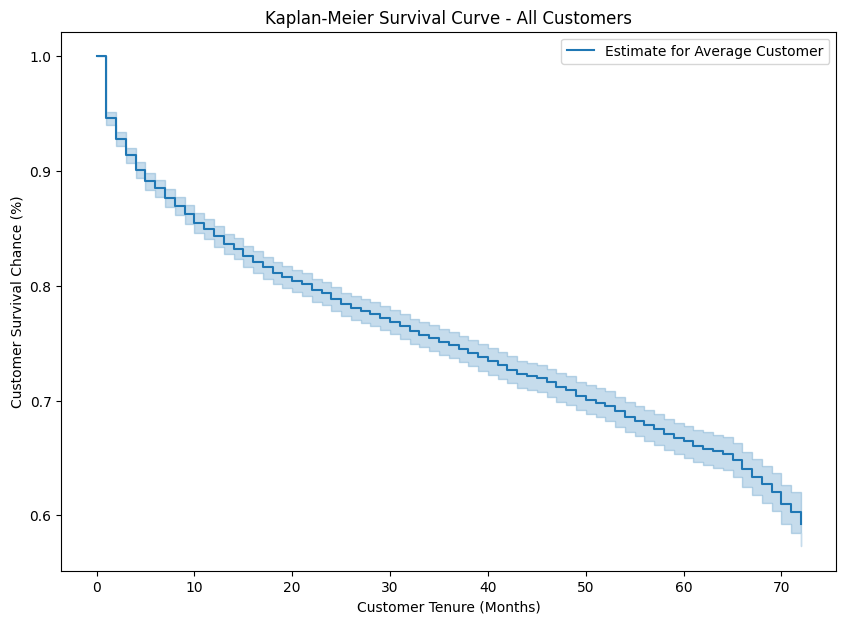

In [ ]:
# fitting kmf to churn data
t = data['tenure'].values
churn = data['Churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve - All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

# Split data into train/test sets
train, test = train_test_split(data, test_size=0.3, random_state=42)

# Fit Kaplan-Meier model on training data
kmf_train = KaplanMeierFitter()
kmf_train.fit(train["tenure"], event_observed=train["Churn"])

# Generate predictions for test set
test_times = test["tenure"].values
test_events = test["Churn"].values

# Predict survival probabilities for each customer in the test set
survival_probs = kmf_train.predict(test_times)

# Convert survival probabilities to risk scores (1 - survival probability)
risk_scores = 1 - survival_probs

# Compute Concordance Index (using risk scores)
c_index = concordance_index(
    test_times,
    risk_scores,
    test_events
)

print(f"Kaplan-Meier Concordance Index: {c_index:.4f}")

# Calculate Brier Score for the test set
churn_probs = 1 - survival_probs
brier_test = brier_score_loss(test_events, churn_probs)
print(f"Kaplan-Meier Brier Score (Test Set): {brier_test:.4f}")

# Evaluate on the entire dataset for comparison
kmf_full = KaplanMeierFitter()
kmf_full.fit(data["tenure"], event_observed=data["Churn"])

# Predict survival probabilities for entire dataset
full_survival_probs = kmf_full.predict(data["tenure"].values)

# Convert survival probabilities to risk scores for the full dataset
full_risk_scores = 1 - full_survival_probs

# Compute C-Index for the full dataset
full_c_index = concordance_index(
    data["tenure"],
    full_risk_scores,
    data["Churn"]
)

print(f"Full Dataset Concordance Index: {full_c_index:.4f}")

# Calculate Brier Score for the full dataset
full_churn_probs = 1 - full_survival_probs
brier_full = brier_score_loss(data["Churn"], full_churn_probs)
print(f"Kaplan-Meier Brier Score (Full Dataset): {brier_full:.4f}")

Kaplan-Meier Concordance Index: 0.9886
Kaplan-Meier Brier Score (Test Set): 0.2500
Full Dataset Concordance Index: 0.9888
Kaplan-Meier Brier Score (Full Dataset): 0.2435


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for churn probabilities
mse_test = mean_squared_error(test_events, churn_probs)
print(f"Kaplan-Meier Mean Squared Error (Test Set): {mse_test:.4f}")


Kaplan-Meier Mean Squared Error (Test Set): 0.2500


In [ ]:
def survival_difference_metric(model, test_data, time_points=None):
    """Calculate mean absolute difference between predicted and actual survival."""
    if time_points is None:
        time_points = np.percentile(test_data['tenure'], [25, 50, 75])

    errors = []
    for t in time_points:
        # Get actual survival (KM estimate on test data)
        kmf_test = KaplanMeierFitter()
        kmf_test.fit(test_data['tenure'], test_data['Churn'])
        actual_survival = kmf_test.predict(t)

        # Get predicted survival
        pred_survival = model.predict(t)

        # Calculate absolute difference
        error = abs(actual_survival - pred_survival)
        errors.append(error)

    return np.mean(errors)

# Calculate the metric
avg_error = survival_difference_metric(kmf, test)
print(f"Average survival difference: {avg_error:.4f}")

Average survival difference: 0.0068


Probability of churning by month 1: 0.0540
Probability of churning by month 3: 0.0863
Probability of churning by month 6: 0.1152
Probability of churning by month 12: 0.1568
Probability of churning by month 24: 0.2113


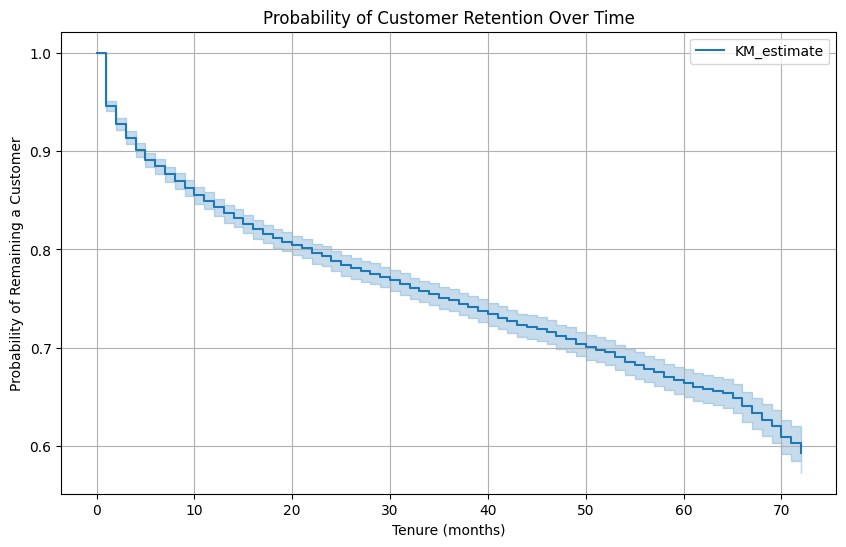

In [ ]:
# Fit the Kaplan-Meier model
kmf = KaplanMeierFitter()
kmf.fit(data['tenure'], data['Churn'])



# 2. Predict for multiple time points
time_points = [1, 3, 6, 12, 24]
for t in time_points:
    churn_prob = 1 - kmf.predict(t)
    print(f"Probability of churning by month {t}: {churn_prob:.4f}")

# 3. Generate full survival curve
survival_curve = kmf.survival_function_
plt.figure(figsize=(10, 6))
kmf.plot()
plt.title("Probability of Customer Retention Over Time")
plt.xlabel("Tenure (months)")
plt.ylabel("Probability of Remaining a Customer")
plt.grid(True)
plt.show()

In [ ]:
from lifelines.statistics import logrank_test

# Example: Compare survival curves between two contract types (or any other segmentation variable)
print(data['Contract'].unique())
group1 = data[data["InternetService"] == 0]
group2 = data[data["InternetService"] == 2]

# Perform the log-rank test
results = logrank_test(group1["tenure"], group2["tenure"], event_observed_A=group1["Churn"], event_observed_B=group2["Churn"])

# Check the p-value
print(f"Log-Rank Test p-value: {results.p_value:.4f}")

[0 1 2]
Log-Rank Test p-value: 0.0000


In [ ]:
# Probability of leaving by 3 months
churn_prob_by_month_3 = 1 - kmf.predict(3)
print(churn_prob_by_month_3)

# # For different customer segments
# kmf.fit(durations[segment_mask], event_observed[segment_mask])
# segment_churn_prob = 1 - kmf.predict(3)

0.08627547820564418


#### CoxPH approach 1

Getting dummies for features having 'No Internet Service' as one of its values since the churn rate for that particular value of the features is **least** compared to other values.

In [ ]:
features_to_drop = ['customerID', 'gender', 'PhoneService', 'MultipleLines']
# engineering numeric columns for Cox Proportional Hazard estimation
churn_hazard_1 = churn_data.drop(features_to_drop, axis=1).copy()

# a lot of variables are encoded as 'Yes' or 'No', lets get these all done at once
binary_features = ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']
for feat in binary_features:
    churn_hazard_1[feat] = (churn_hazard_1[feat] == 'Yes').astype(int)

# let's one hot encode the remaining categorical features
ohe_features = ['InternetService', 'Contract', 'PaymentMethod',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV','StreamingMovies']

churn_hazard_1 = pd.get_dummies(churn_hazard_1,
                              drop_first=True,
                              columns=ohe_features,
                              dtype=int)

churn_hazard_1['Churn'] = churn_hazard_1['Churn'].map({'Yes': 1, 'No': 0})

scaler = StandardScaler()

columns_to_scale = ['MonthlyCharges', 'TotalCharges']

# Standardizing the columns
churn_hazard_1[columns_to_scale] = scaler.fit_transform(churn_hazard_1[columns_to_scale])


In [ ]:
churn_hazard_1.dtypes

SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
InternetService_Fiber optic                int64
InternetService_No                         int64
Contract_One year                          int64
Contract_Two year                          int64
PaymentMethod_Credit card (automatic)      int64
PaymentMethod_Electronic check             int64
PaymentMethod_Mailed check                 int64
OnlineSecurity_No internet service         int64
OnlineSecurity_Yes                         int64
OnlineBackup_No internet service           int64
OnlineBackup_Yes                           int64
DeviceProtection_No internet service       int64
DeviceProtection_Yes                       int64
TechSupport_No internet service            int64
TechSupport_Yes                            int64
StreamingTV_No internet service            int64
StreamingTV_Yes                            int64
StreamingMovies_No internet service        int64
StreamingMovies_Yes                        int64
dtype: object

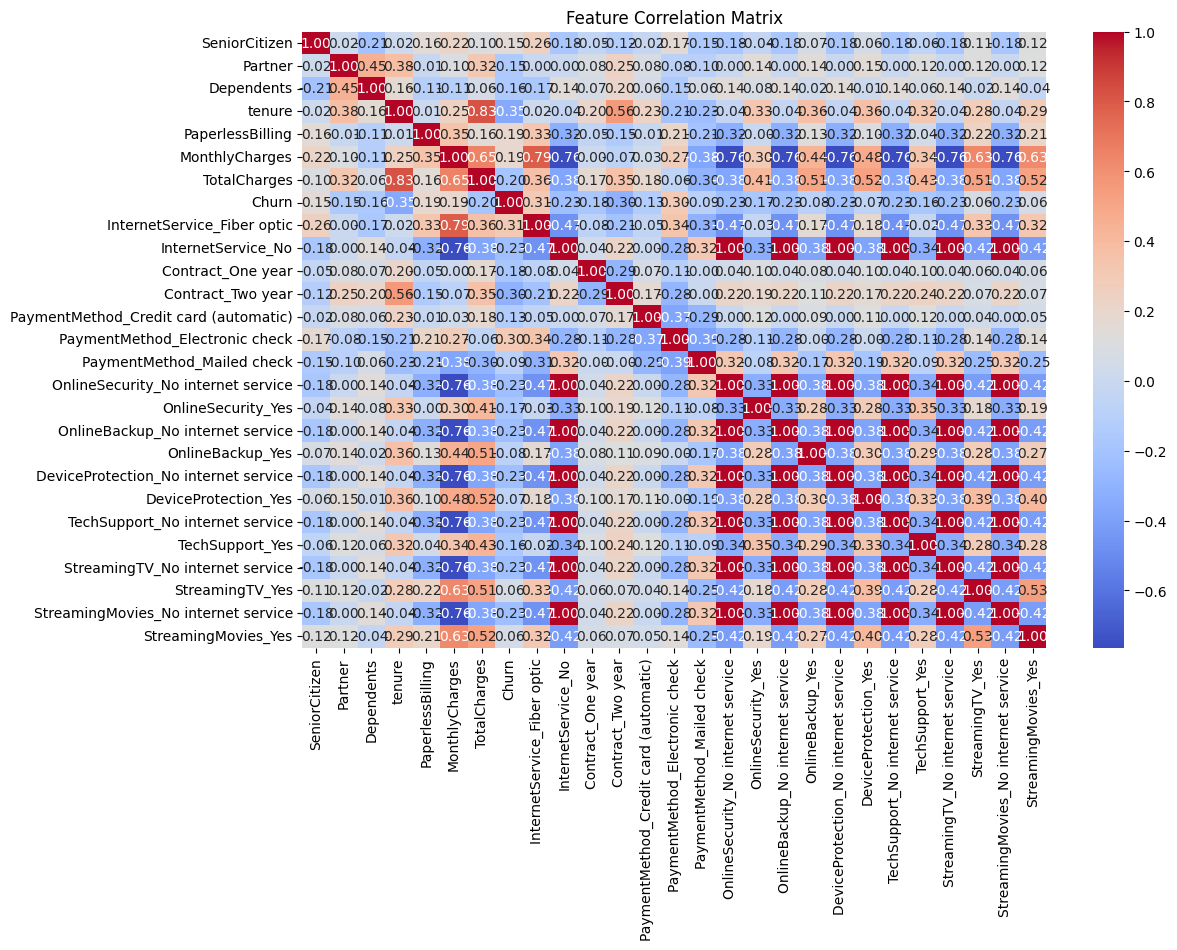

In [ ]:
corr_matrix = churn_hazard_1.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
churn_hazard_1.isna().sum()

SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
InternetService_Fiber optic              0
InternetService_No                       0
Contract_One year                        0
Contract_Two year                        0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV_No internet service          0
StreamingTV_Yes                          0
StreamingMovies_No internet service      0
StreamingMovies_Yes                      0
dtype: int64

                                  Feature         VIF
18   DeviceProtection_No internet service  100.000000
14     OnlineSecurity_No internet service  100.000000
24    StreamingMovies_No internet service  100.000000
16       OnlineBackup_No internet service  100.000000
8                      InternetService_No  100.000000
20        TechSupport_No internet service  100.000000
22        StreamingTV_No internet service  100.000000
5                          MonthlyCharges   20.794168
3                                  tenure   14.968880
7             InternetService_Fiber optic    9.044964
6                            TotalCharges    7.636896
10                      Contract_Two year    3.447646
23                        StreamingTV_Yes    3.139843
25                    StreamingMovies_Yes    3.124303
4                        PaperlessBilling    2.850512
1                                 Partner    2.817109
12         PaymentMethod_Electronic check    2.746199
19                   DeviceP

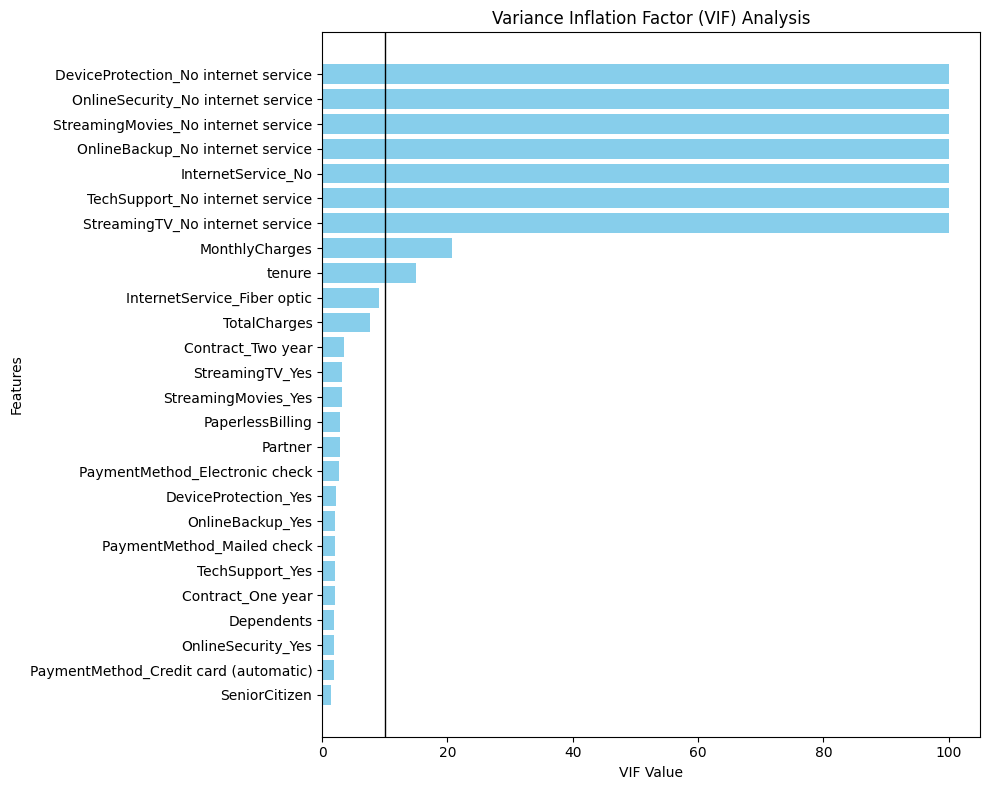

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Get numerical columns only (excluding tenure and Churn)
X = churn_hazard_1.drop(columns=["Churn"])

# Compute VIF for each column
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data['VIF'] = vif_data['VIF'].replace([np.inf, -np.inf], 100)

vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.sort_values(by="VIF", ascending=False))

plt.figure(figsize=(10, 8))
plt.barh(vif_data['Feature'], vif_data['VIF'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show highest VIF at the top
plt.xlabel('VIF Value')
plt.ylabel('Features')
plt.axvline(x=10, color='black', linewidth=1)  # Add a vertical line at VIF=10
plt.title('Variance Inflation Factor (VIF) Analysis') #add title
plt.tight_layout()
plt.show()

In [ ]:
# Create a new DataFrame excluding features with VIF > 15
vif_threshold = 15
churn_hazard_2 = churn_hazard_1.drop(columns=vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist())

print(churn_hazard_2.head())


   SeniorCitizen  Partner  Dependents  tenure  PaperlessBilling  TotalCharges  \
0              0        1           0       1                 1     -0.992611   
1              0        0           0      34                 0     -0.172165   
2              0        0           0       2                 1     -0.958066   
3              0        0           0      45                 0     -0.193672   
4              0        0           0       2                 1     -0.938874   

   Churn  InternetService_Fiber optic  Contract_One year  Contract_Two year  \
0      0                            0                  0                  0   
1      0                            0                  1                  0   
2      1                            0                  0                  0   
3      0                            0                  1                  0   
4      1                            1                  0                  0   

   PaymentMethod_Credit card (automati

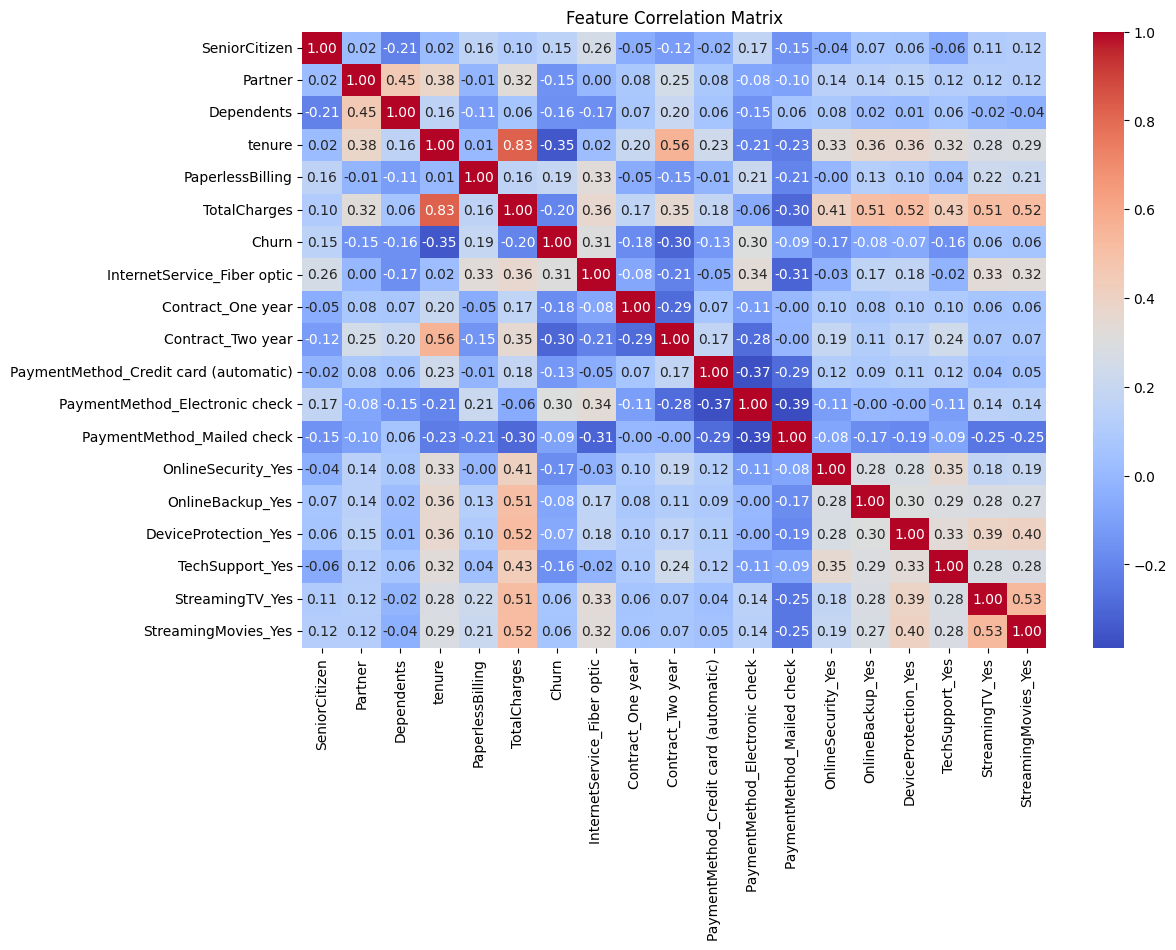

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = churn_hazard_2.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
X_reduced = selector.fit_transform(X)

print("Remaining Features:", X.columns[selector.get_support()])


Remaining Features: Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype='object')


In [ ]:
cph = CoxPHFitter()
cph.fit(churn_hazard_2, duration_col="tenure", event_col="Churn")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12841.68
         time fit was run = 2025-02-23 21:38:39 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                          0.06      1.06      0.06           -0.05            0.17                0.95                1.18
Partner                               -0.23      0.80      0.06           -0.33           -0.12                0.72                0.89
Dependents                            -0.14      0.87      0.07           -0.28           -0.01                0.75                0.99
PaperlessBilling                       0.22      1.25      0.06            0.11            0.33                1.12                1.40
TotalCharges                          -3.02      0.05      0.08           -3.17           -2.87                0.04                0.06
InternetService_Fiber optic            1.95      7.01      0.07            1.81            2.09                6.09                8.07
Contract_One year                     -1.71      0.18      0.10           -1.90           -1.51                0.15                0.22
Contract_Two year                     -4.49      0.01      0.18           -4.85           -4.13                0.01                0.02
PaymentMethod_Credit card (automatic) -0.00      1.00      0.09           -0.18            0.17                0.83                1.19
PaymentMethod_Electronic check         0.42      1.52      0.07            0.28            0.56                1.32                1.75
PaymentMethod_Mailed check             0.45      1.57      0.09            0.28            0.62                1.32                1.86
OnlineSecurity_Yes                     0.08      1.08      0.07           -0.05            0.21                0.95                1.23
OnlineBackup_Yes                       0.09      1.09      0.05           -0.02            0.20                0.98                1.22
DeviceProtection_Yes                   0.21      1.23      0.05            0.10            0.32                1.11                1.37
TechSupport_Yes                        0.14      1.15      0.07            0.01            0.27                1.01                1.31
StreamingTV_Yes                        0.41      1.51      0.05            0.30            0.51                1.35                1.67
StreamingMovies_Yes                    0.40      1.50      0.05            0.30            0.51                1.35                1.67

                                       cmp to      z      p  -log2(p)
covariate                                                            
SeniorCitizen                            0.00   1.02   0.31      1.71
Partner                                  0.00  -4.09 <0.005     14.48
Dependents                               0.00  -2.05   0.04      4.64
PaperlessBilling                         0.00   3.89 <0.005     13.27
TotalCharges                             0.00 -40.17 <0.005       inf
InternetService_Fiber optic              0.00  27.08 <0.005    533.92
Contract_One year                        0.00 -17.37 <0.005    222.11
Contract_Two year                        0.00 -24.31 <0.005    431.12
PaymentMethod_Credit card (automatic)    0.00  -0.03   0.97      0.04
PaymentMethod_Electronic check           0.00   5.74 <0.005     26.69
PaymentMethod_Mailed check               0.00   5.18 <0.005     22.11
OnlineSecurity_Yes                       0.00   1.21   0.23      2.15
OnlineBackup_Yes                         0.00   1.63   0.10      3.29


In [ ]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(churn_hazard_2, duration_col="tenure", event_col="Churn")

# Calculate Concordance Index
c_index = concordance_index(churn_hazard_1["tenure"], -cph.predict_partial_hazard(churn_hazard_1), churn_hazard_1["Churn"])
print(f"Cox-PH Model Concordance Index: {c_index:.4f}")


Cox-PH Model Concordance Index: 0.9265


In [ ]:
from sklearn.metrics import brier_score_loss

# Predict probabilities
pred_probs = 1 - cph.predict_survival_function(churn_hazard_2).T

# Compute Brier Score
brier_score = brier_score_loss(churn_hazard_2["Churn"], pred_probs.mean(axis=1))
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.1908


In [ ]:
# Predict survival function for a new customer


# Predict survival function
survival_curve = cph.predict_survival_function(churn_hazard_2)

# Probability of surviving after 3 months
survival_3_months = survival_curve.loc[3].values[0]
print(f"Probability of customer staying after 3 months: {survival_3_months:.4f}")

# Probability of churning after 3 months
churn_prob = 1 - survival_3_months
print(f"Probability of churning within 3 months: {churn_prob:.4f}")


Probability of customer staying after 3 months: 0.9153
Probability of churning within 3 months: 0.0847


In [ ]:
cph.check_assumptions(churn_hazard_2, p_value_threshold=0.05)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
Contract_One year                     km            159.78 <0.005    119.25
                                      rank          128.85 <0.005     96.78
Contract_Two year                     km            120.76 <0.005     90.90
                                      rank           88.31 <0.005     67.28
Dependents                            km              0.01   0.93      0.11
                                      rank            0.01   0.93      0.10
DeviceProtection_Yes                  km              5.69   0.02      5.88
                                      rank            8.27 <0.005      7.96
InternetService_Fiber optic           km            137.96 <0.005    103.41
                                      rank          208.70 <0.005    154.73
OnlineBackup_Yes                      km              8.05 <0.005      7.78
                                      rank           11.00 <0.005     10.10
OnlineSecurity_Yes                    km              9.42 <0.005      8.86
                                      rank           14.14 <0.005     12.53
PaperlessBilling                      km              0.06   0.81      0.30
                                      rank            0.02   0.88      0.18
Partner                               km              1.67   0.20      2.35
                                      rank            3.48   0.06      4.01
PaymentMethod_Credit card (automatic) km              2.63   0.11      3.25
                                      rank            2.11   0.15      2.77
PaymentMethod_Electronic check        km              0.10   0.75      0.41
                                      rank            0.14   0.71      0.49
PaymentMethod_Mailed check            km              0.22   0.64      0.65
                                      rank            0.34   0.56      0.83
SeniorCitizen                         km              2.86   0.09      3.46
                                      rank            1.52   0.22      2.20
StreamingMovies_Yes                   km             20.87 <0.005     17.64
                                      rank           28.10 <0.005     23.05
StreamingTV_Yes                       km             29.29 <0.005     23.93
                                      rank           36.48 <0.005     29.28
TechSupport_Yes                       km              9.59 <0.005      9.00
                                      rank           13.63 <0.005     12.13
TotalCharges                          km            407.05 <0.005    298.29
                                      rank          158.41 <0.005    118.26



1. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'TotalCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'TotalCharges' using pd.cut, and then specify it in
`strata=['TotalCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'InternetService_Fiber optic' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['InternetService_Fiber
optic', ...]` in the call in `.fit`. See documentation in link [E] below.

3. Variable 'Contract_One year' failed the non-proportional test: p-valu

[]

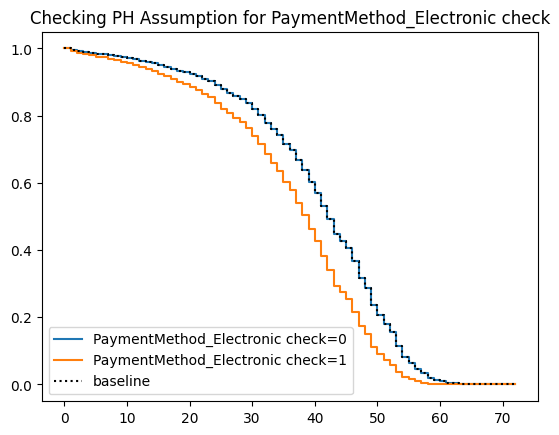

In [ ]:
cph.plot_partial_effects_on_outcome(covariates=['PaymentMethod_Electronic check'], values=[0, 1])
plt.title("Checking PH Assumption for PaymentMethod_Electronic check")
plt.show()

                                       test_statistic             p  \
Contract_One year                          128.845479  7.330906e-30   
Contract_Two year                           88.309827  5.596472e-21   
Dependents                                   0.007513  9.309277e-01   
DeviceProtection_Yes                         8.271057  4.028205e-03   
InternetService_Fiber optic                208.703748  2.634362e-47   
OnlineBackup_Yes                            10.995826  9.131730e-04   
OnlineSecurity_Yes                          14.141874  1.695278e-04   
PaperlessBilling                             0.022715  8.801995e-01   
Partner                                      3.482594  6.201744e-02   
PaymentMethod_Credit card (automatic)        2.110529  1.462887e-01   
PaymentMethod_Electronic check               0.136601  7.116839e-01   
PaymentMethod_Mailed check                   0.338185  5.608787e-01   
SeniorCitizen                                1.521983  2.173196e-01   
Stream

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
Contract_One year                     km            159.78 <0.005    119.25
                                      rank          128.85 <0.005     96.78
Contract_Two year                     km            120.76 <0.005     90.90
                                      rank           88.31 <0.005     67.28
Dependents                            km              0.01   0.93      0.11
                                      rank            0.01   0.93      0.10
DeviceProtection_Yes                  km              5.69   0.02      5.88
                                      rank            8.27 <0.005      7.96
InternetService_Fiber optic           km            137.96 <0.005    103.41
                                      rank          208.70 <0.005    154.73
OnlineBackup_Yes                      km              8.05 <0.005      7.78
                                      rank           11.00 <0.005     10.10
OnlineSecurity_Yes                    km              9.42 <0.005      8.86
                                      rank           14.14 <0.005     12.53
PaperlessBilling                      km              0.06   0.81      0.30
                                      rank            0.02   0.88      0.18
Partner                               km              1.67   0.20      2.35
                                      rank            3.48   0.06      4.01
PaymentMethod_Credit card (automatic) km              2.63   0.11      3.25
                                      rank            2.11   0.15      2.77
PaymentMethod_Electronic check        km              0.10   0.75      0.41
                                      rank            0.14   0.71      0.49
PaymentMethod_Mailed check            km              0.22   0.64      0.65
                                      rank            0.34   0.56      0.83
SeniorCitizen                         km              2.86   0.09      3.46
                                      rank            1.52   0.22      2.20
StreamingMovies_Yes                   km             20.87 <0.005     17.64
                                      rank           28.10 <0.005     23.05
StreamingTV_Yes                       km             29.29 <0.005     23.93
                                      rank           36.48 <0.005     29.28
TechSupport_Yes                       km              9.59 <0.005      9.00
                                      rank           13.63 <0.005     12.13
TotalCharges                          km            407.05 <0.005    298.29
                                      rank          158.41 <0.005    118.26



1. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'TotalCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'TotalCharges' using pd.cut, and then specify it in
`strata=['TotalCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'InternetService_Fiber optic' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['InternetService_Fiber
optic', ...]` in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping l

[[<Axes: xlabel='rank-transformed time\n(p=0.2173)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0907)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0620)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1962)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9309)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9252)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8802)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8138)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1463)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1051)'>],
 [<Axes: xlabel='rank-transformed tim

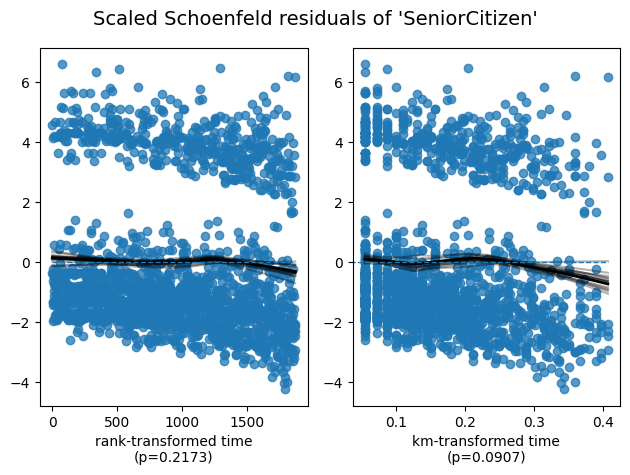

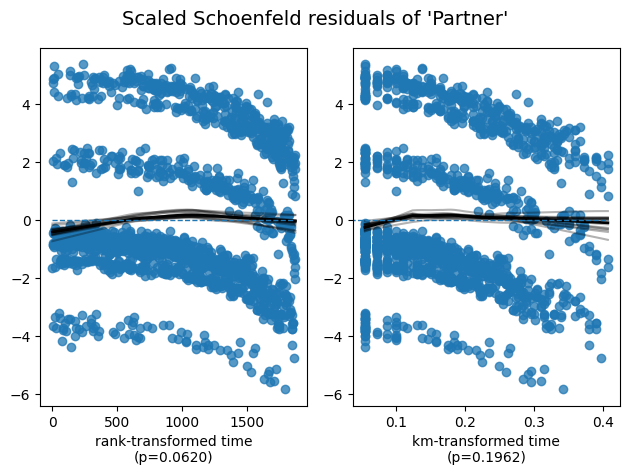

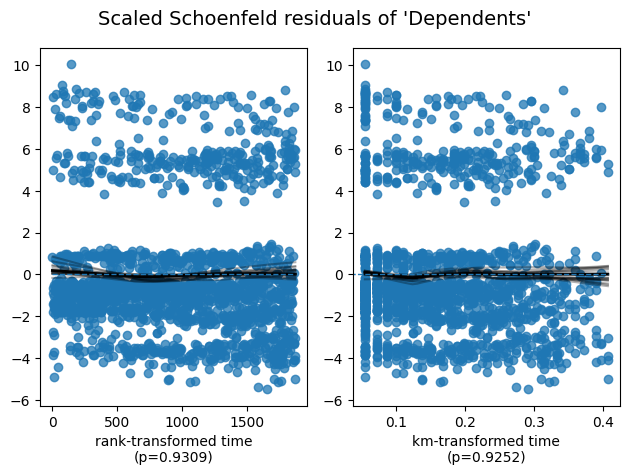

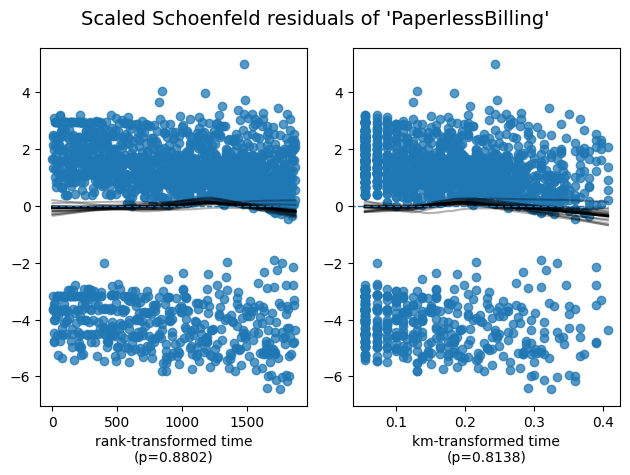

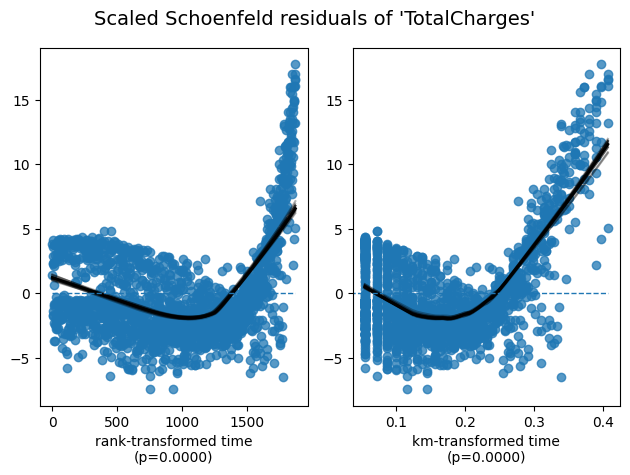

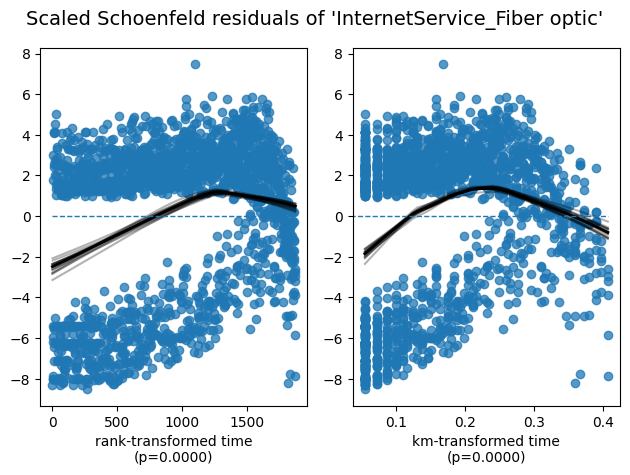

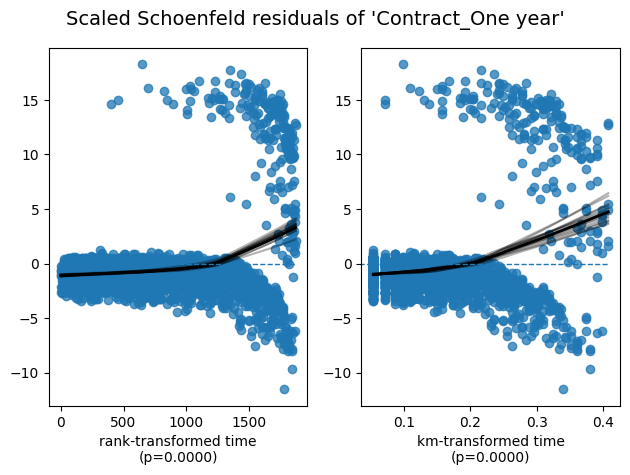

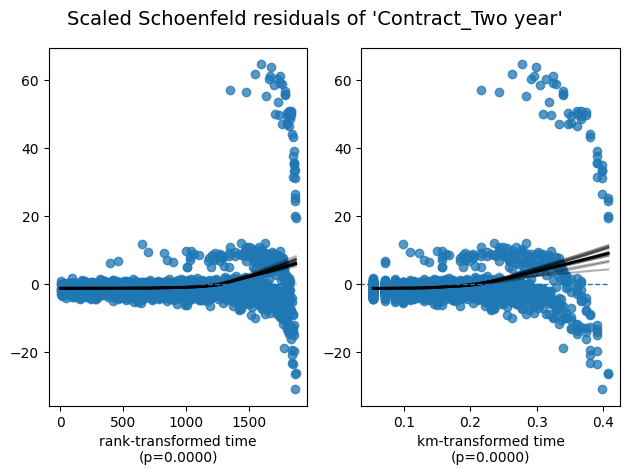

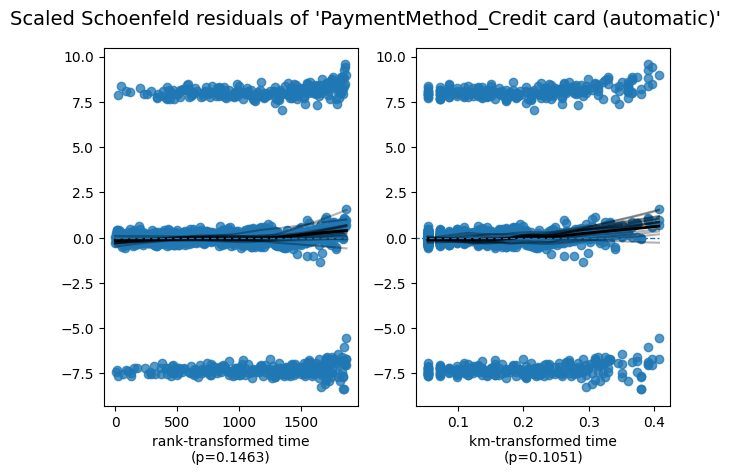

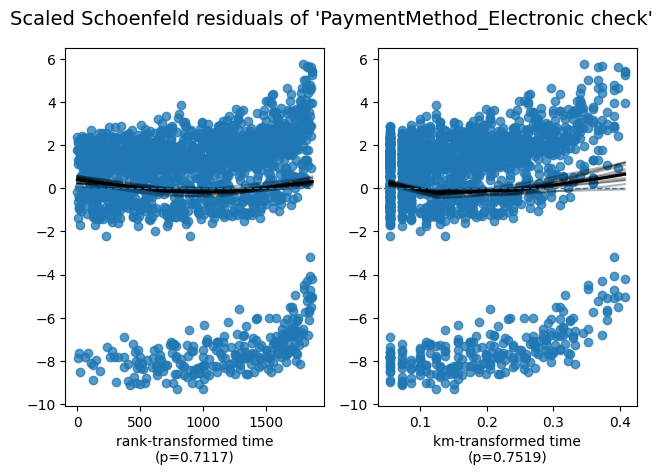

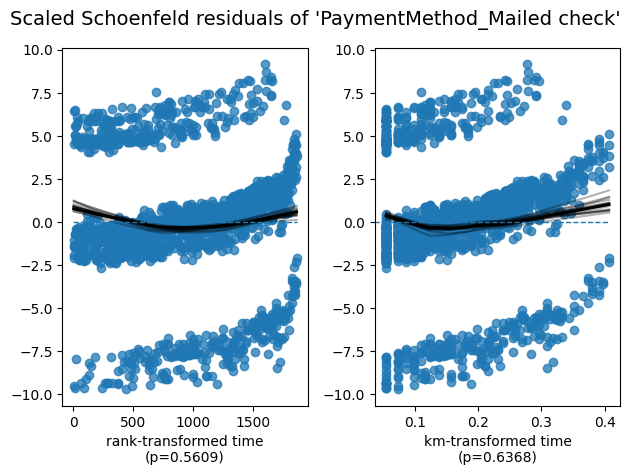

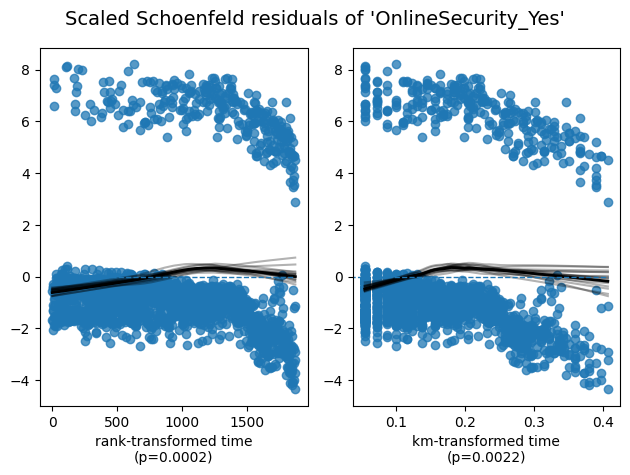

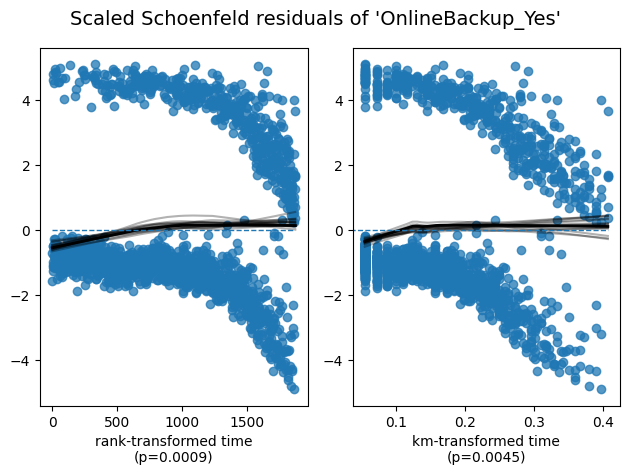

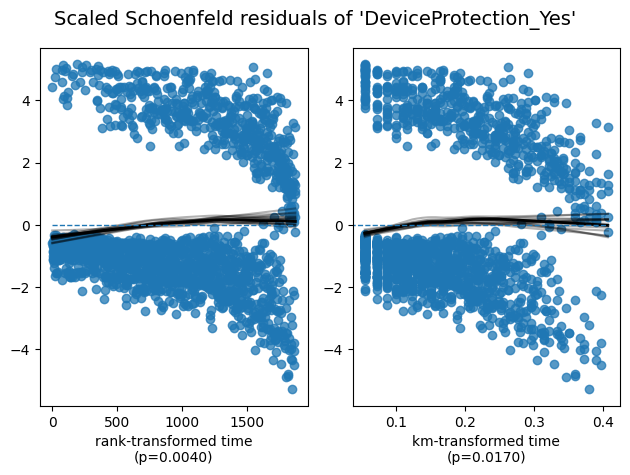

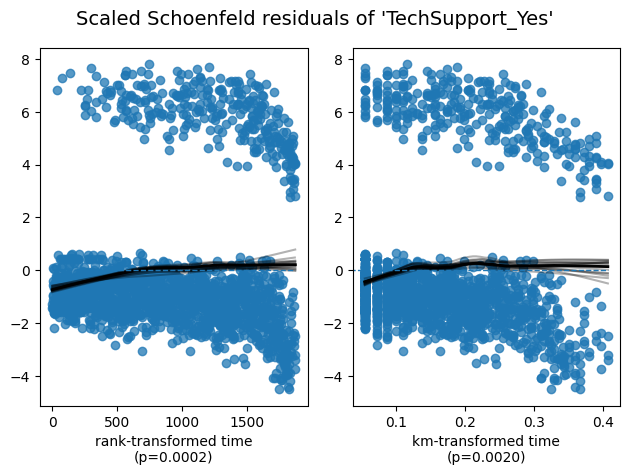

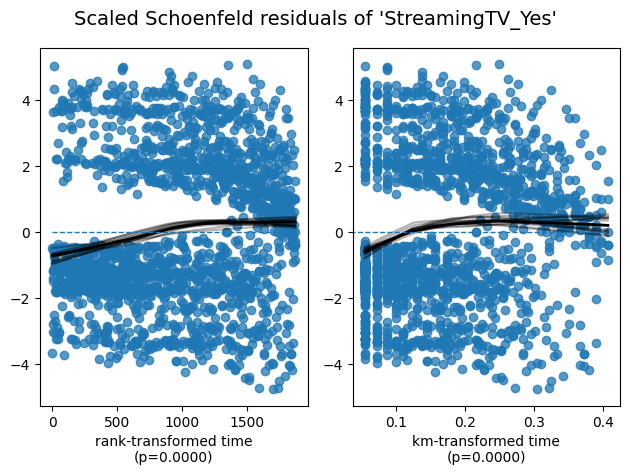

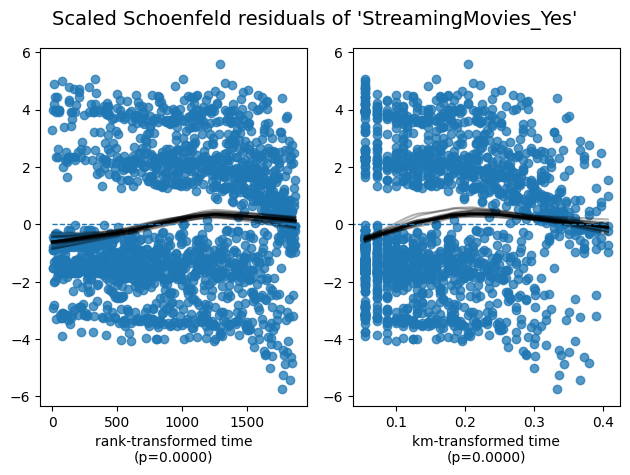

In [ ]:
from lifelines.statistics import proportional_hazard_test


# Test PH assumption using Schoenfeld residuals
results = proportional_hazard_test(cph, churn_hazard_2, time_transform='rank')

# Print test results
print(results.summary)

# Plot Schoenfeld residuals for PaymentMethod_Electronic check
cph.check_assumptions(churn_hazard_2, p_value_threshold=0.05, show_plots=True)

In [ ]:
churn_hazard_1[['OnlineBackup_No internet service','StreamingMovies_No internet service']]

OnlineBackup_No internet service  StreamingMovies_No internet service
0                                    0                                    0
1                                    0                                    0
2                                    0                                    0
3                                    0                                    0
4                                    0                                    0
...                                ...                                  ...
7038                                 0                                    0
7039                                 0                                    0
7040                                 0                                    0
7041                                 0                                    0
7042                                 0                                    0

[7043 rows x 2 columns]

#### CoxPH approach 2

- Not fitting dummies for features having 'No Internet Service' as aone of its values since the feature **InternetService** contains 0 indicating no internet.

- Removing TotalCharges since it is highly correlated with Tenure is nigh perfectly correlated with MonthlyCharges * Tenure, so doesn't add additional info.

##### Pre-requisite EDA

In [ ]:
features_to_drop = ['customerID', 'gender', 'PhoneService', 'MultipleLines', 'TotalCharges']
# engineering numeric columns for Cox Proportional Hazard estimation
churn_hazard_2 = churn_data.drop(features_to_drop, axis=1).copy()

# a lot of variables are encoded as 'Yes' or 'No', lets get these all done at once
binary_features = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV','StreamingMovies', 'PaperlessBilling', 'SeniorCitizen']
for feat in binary_features:
    churn_hazard_2[feat] = (churn_hazard_2[feat] == 'Yes').astype(int)

# let's one hot encode the remaining categorical features
ohe_features = ['InternetService', 'Contract', 'PaymentMethod']

churn_hazard_2 = pd.get_dummies(churn_hazard_2,
                              drop_first=True,
                              columns=ohe_features,
                              dtype=int)


churn_hazard_2['Churn'] = churn_hazard_2['Churn'].map({'Yes': 1, 'No': 0})
# scaler = StandardScaler()

# columns_to_scale = ['MonthlyCharges']

# Standardizing the columns
# churn_hazard_2[columns_to_scale] = scaler.fit_transform(churn_hazard_2[columns_to_scale])


InternetService_No                      -0.763557
PaymentMethod_Mailed check              -0.377437
Dependents                              -0.113890
Contract_Two year                       -0.074681
Contract_One year                        0.004904
PaymentMethod_Credit card (automatic)    0.030550
Partner                                  0.096848
Churn                                    0.193356
SeniorCitizen                            0.220173
tenure                                   0.247900
PaymentMethod_Electronic check           0.271625
OnlineSecurity                           0.296594
TechSupport                              0.338304
PaperlessBilling                         0.352150
OnlineBackup                             0.441780
DeviceProtection                         0.482692
StreamingMovies                          0.627429
StreamingTV                              0.629603
InternetService_Fiber optic              0.787066
MonthlyCharges                           1.000000


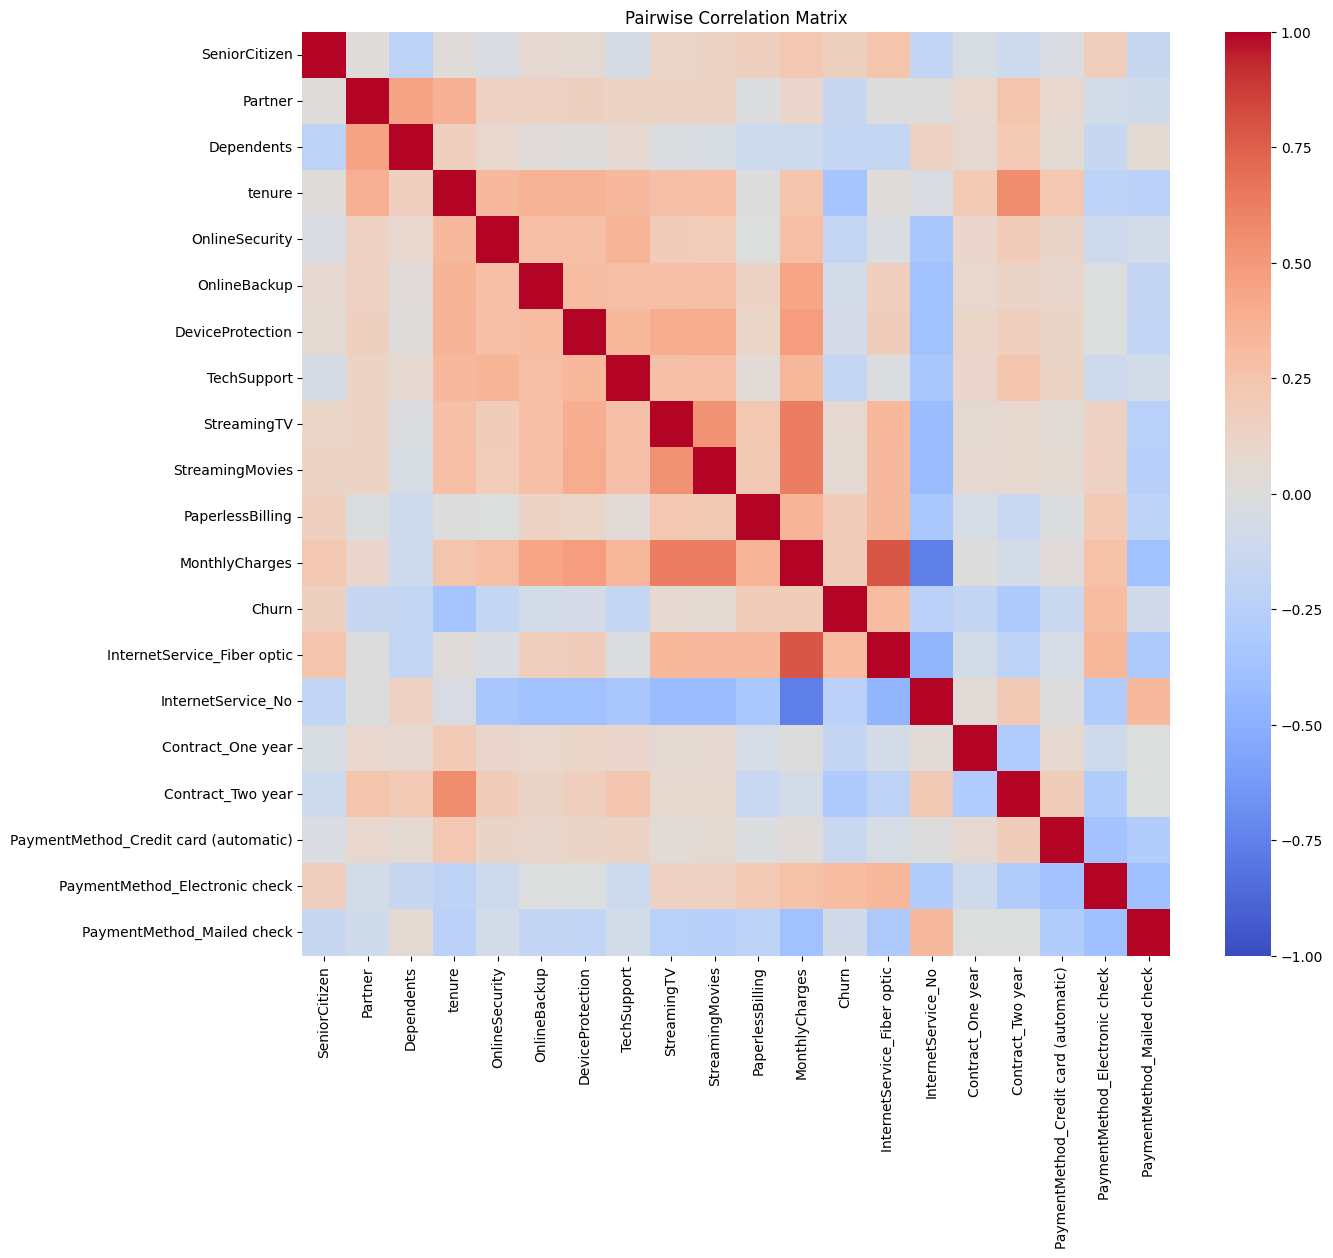

In [ ]:
correlation_matrix = churn_hazard_2.corr()
print(correlation_matrix['MonthlyCharges'].sort_values())

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlation Matrix')
plt.show()


In [ ]:
churn_hazard_2.dtypes

SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
OnlineSecurity                             int64
OnlineBackup                               int64
DeviceProtection                           int64
TechSupport                                int64
StreamingTV                                int64
StreamingMovies                            int64
PaperlessBilling                           int64
MonthlyCharges                           float64
Churn                                      int64
InternetService_Fiber optic                int64
InternetService_No                         int64
Contract_One year                          int64
Contract_Two year                          int64
PaymentMethod_Credit card (automatic)      int64
PaymentMethod_Electronic check             int64
PaymentMethod_Mailed check                 int64
dtype: object

In [ ]:
# Looking at VIF for the columns

# Define the predictor variables
X = churn_hazard_2.drop(columns=['Churn'])

# Add a constant to the model (intercept)
X = add_constant(X)

# Calculate VIF for each feature
vif_df_2 = pd.DataFrame()
vif_df_2['Feature'] = X.columns
vif_df_2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

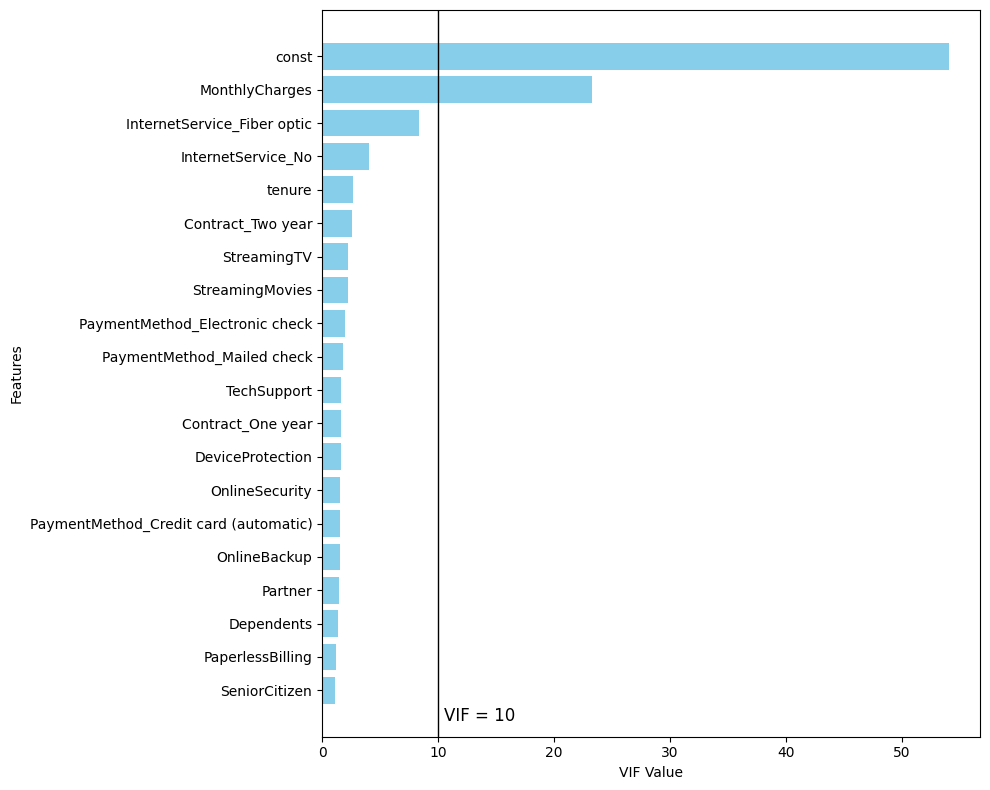

In [ ]:
# Replace infinite VIF values with a capped high value
vif_df_2['VIF'] = vif_df_2['VIF'].replace([np.inf, -np.inf], 100)

# Sort VIF values in descending order
vif_df_2 = vif_df_2.sort_values(by='VIF', ascending=False)

# Plot the VIF values
plt.figure(figsize=(10, 8))
plt.barh(vif_df_2['Feature'], vif_df_2['VIF'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show highest VIF at the top
plt.xlabel('VIF Value')
plt.ylabel('Features')
plt.axvline(x=10, color='black', linewidth=1)

# Add the label for the vertical line
plt.gca().text(10.5, len(vif_df_2) - 0.5, 'VIF = 10', color='black', fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()


In [ ]:
correlation_matrix = churn_hazard_1.corr()
print(correlation_matrix['TotalCharges'].sort_values())


StreamingTV_No internet service         -0.375223
TechSupport_No internet service         -0.375223
DeviceProtection_No internet service    -0.375223
OnlineBackup_No internet service        -0.375223
OnlineSecurity_No internet service      -0.375223
InternetService_No                      -0.375223
StreamingMovies_No internet service     -0.375223
PaymentMethod_Mailed check              -0.295758
Churn                                   -0.198324
PaymentMethod_Electronic check          -0.059246
Dependents                               0.062078
SeniorCitizen                            0.103006
PaperlessBilling                         0.158574
Contract_One year                        0.170814
PaymentMethod_Credit card (automatic)    0.182915
Partner                                  0.317504
Contract_Two year                        0.354481
InternetService_Fiber optic              0.361655
OnlineSecurity_Yes                       0.411651
TechSupport_Yes                          0.431883


##### Fitting coxph on churn_hazard_2

In [ ]:
churn_hazard_2.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'Churn',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
cph = lifelines.CoxPHFitter()
cph.fit(churn_hazard_2, duration_col='tenure', event_col='Churn', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13915.29
         time fit was run = 2025-02-23 16:12:17 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                         -0.11      0.89      0.06           -0.22           -0.00                0.80                1.00
Partner                               -0.53      0.59      0.05           -0.64           -0.42                0.53                0.66
Dependents                            -0.04      0.96      0.07           -0.17            0.10                0.84                1.10
OnlineSecurity                        -0.57      0.57      0.07           -0.70           -0.43                0.49                0.65
OnlineBackup                          -0.59      0.55      0.06           -0.71           -0.48                0.49                0.62
DeviceProtection                      -0.25      0.78      0.06           -0.36           -0.14                0.70                0.87
TechSupport                           -0.31      0.73      0.07           -0.45           -0.18                0.64                0.84
StreamingTV                            0.09      1.10      0.07           -0.04            0.22                0.96                1.25
StreamingMovies                       -0.00      1.00      0.07           -0.13            0.13                0.88                1.14
PaperlessBilling                       0.16      1.17      0.06            0.05            0.27                1.05                1.31
MonthlyCharges                        -0.02      0.98      0.00           -0.02           -0.01                0.98                0.99
InternetService_Fiber optic            0.82      2.26      0.16            0.51            1.12                1.66                3.08
InternetService_No                    -1.37      0.25      0.13           -1.63           -1.10                0.20                0.33
Contract_One year                     -1.61      0.20      0.09           -1.78           -1.43                0.17                0.24
Contract_Two year                     -3.25      0.04      0.17           -3.58           -2.93                0.03                0.05
PaymentMethod_Credit card (automatic) -0.07      0.93      0.09           -0.25            0.11                0.78                1.11
PaymentMethod_Electronic check         0.60      1.82      0.07            0.46            0.74                1.58                2.09
PaymentMethod_Mailed check             0.61      1.84      0.09            0.44            0.78                1.55                2.19

                                       cmp to      z      p  -log2(p)
covariate                                                            
SeniorCitizen                            0.00  -1.97   0.05      4.37
Partner                                  0.00  -9.64 <0.005     70.70
Dependents                               0.00  -0.57   0.57      0.82
OnlineSecurity                           0.00  -8.02 <0.005     49.71
OnlineBackup                             0.00 -10.17 <0.005     78.29
DeviceProtection                         0.00  -4.29 <0.005     15.80
TechSupport                              0.00  -4.55 <0.005     17.48
StreamingTV                              0.00   1.40   0.16      2.62
StreamingMovies                          0.00  -0.03   0.98      0.03
PaperlessBilling                         0.00   2.80   0.01      7.60
MonthlyCharges                           0.00  -4.00 <0.005     13.94
Inte

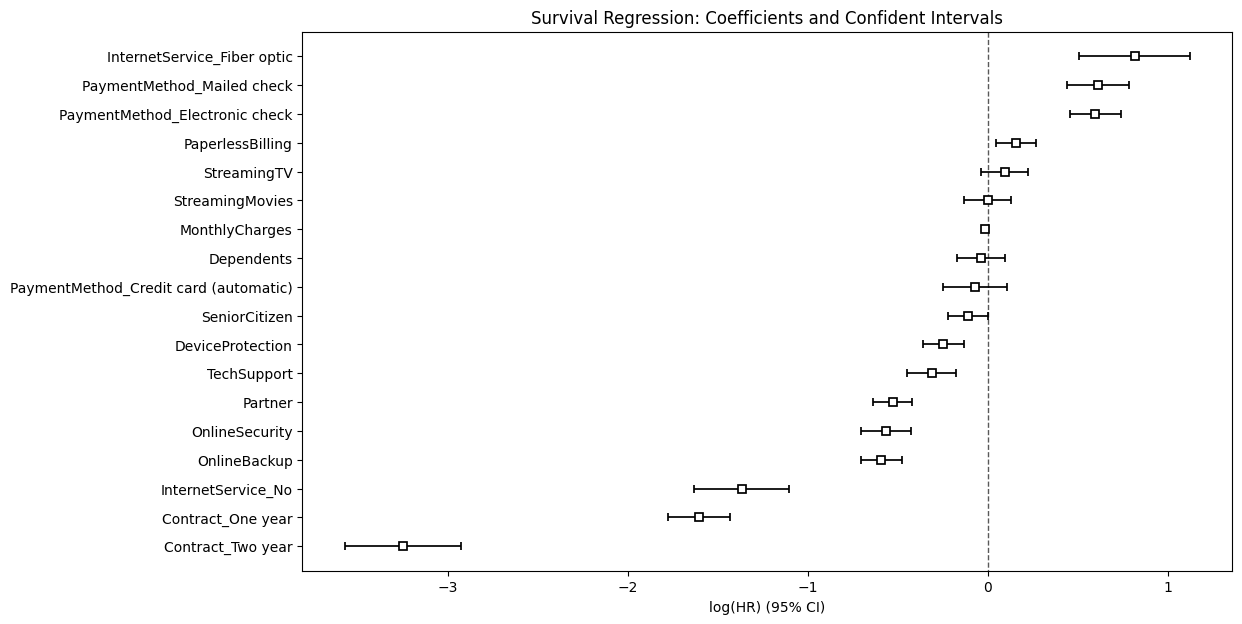

In [ ]:
# plotting coefficients

fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef);

Checking Assumptions with check_assumptions:
The check_assumptions method in lifelines helps diagnose whether the proportional hazards assumption holds. Here's what it does:

Testing Time-Varying Covariates:

It checks whether the effect of any covariate (e.g., monthly charges or tenure) on the hazard changes over time.
It uses statistical tests and visualizations (e.g., Schoenfeld residuals plots) to detect time-dependent relationships.
Output:

Plots: Residual-based diagnostics showing whether any covariate's effect deviates from proportionality.
Warnings or Flags: If any covariate significantly violates the assumption, it identifies them for further inspection.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
Contract_One year                     km             54.84 <0.005     42.80
                                      rank           40.54 <0.005     32.27
Contract_Two year                     km             31.38 <0.005     25.49
                                      rank           18.07 <0.005     15.52
Dependents                            km              0.01   0.94      0.10
                                      rank            0.02   0.89      0.16
DeviceProtection                      km              1.97   0.16      2.64
                                      rank            2.24   0.13      2.89
InternetService_Fiber optic           km              0.17   0.68      0.55
                                      rank            0.11   0.74      0.44
InternetService_No                    km              0.36   0.55      0.87
                                      rank            0.15   0.70      0.51
MonthlyCharges                        km              3.77   0.05      4.26
                                      rank            3.63   0.06      4.14
OnlineBackup                          km              4.85   0.03      5.17
                                      rank            3.96   0.05      4.42
OnlineSecurity                        km              6.64   0.01      6.65
                                      rank            8.02 <0.005      7.76
PaperlessBilling                      km              0.04   0.85      0.23
                                      rank            0.04   0.85      0.23
Partner                               km              4.17   0.04      4.60
                                      rank            5.55   0.02      5.76
PaymentMethod_Credit card (automatic) km              0.63   0.43      1.23
                                      rank            0.76   0.38      1.38
PaymentMethod_Electronic check        km              3.76   0.05      4.25
                                      rank            4.75   0.03      5.09
PaymentMethod_Mailed check            km              6.44   0.01      6.49
                                      rank            8.81 <0.005      8.39
SeniorCitizen                         km              0.05   0.82      0.28
                                      rank            0.13   0.71      0.49
StreamingMovies                       km              2.57   0.11      3.20
                                      rank            2.70   0.10      3.31
StreamingTV                           km              4.40   0.04      4.79
                                      rank            4.25   0.04      4.67
TechSupport                           km              7.61   0.01      7.43
                                      rank            8.27 <0.005      7.96



1. Variable 'Partner' failed the non-proportional test: p-value is 0.0184.

   Advice: with so few unique values (only 2), you can include `strata=['Partner', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'OnlineSecurity' failed the non-proportional test: p-value is 0.0046.

   Advice: with so few unique values (only 2), you can include `strata=['OnlineSecurity', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'OnlineBackup' failed the non-proportional test: p-value is 0.0277.

   Advice: with so few unique values (only 2), you can include `strata=['OnlineBackup', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


4. Variable 'TechSupport' 

[[<Axes: xlabel='rank-transformed time\n(p=0.7144)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8246)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0184)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0412)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8945)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9354)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0046)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0099)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0467)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0277)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1347)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1605)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0040)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0058)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0391)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0360)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1005)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1087)'>],
 [<Axes: xlabel='rank-transformed tim

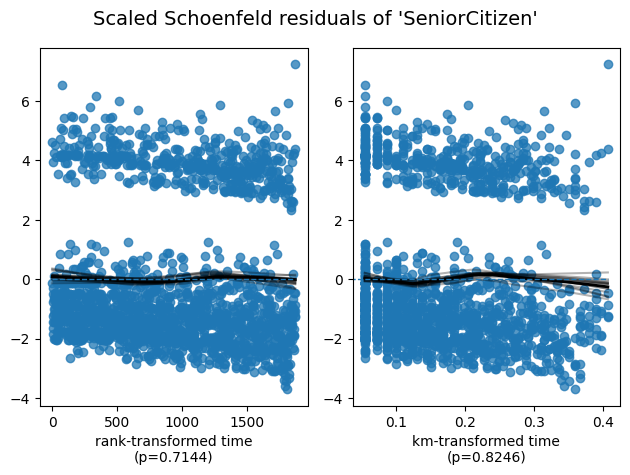

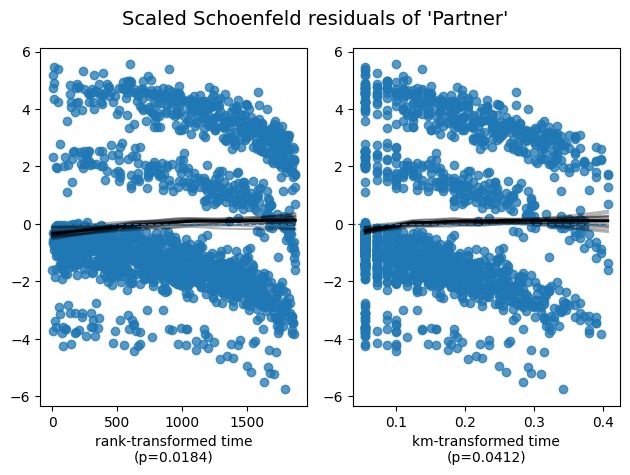

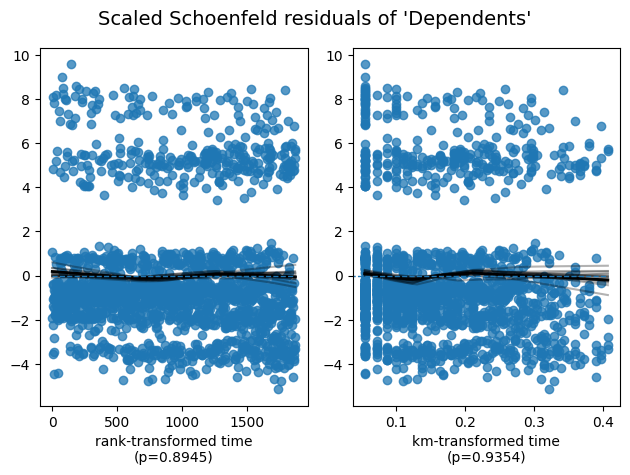

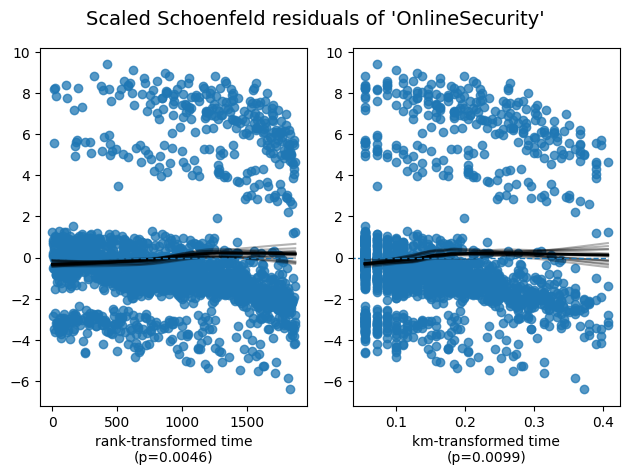

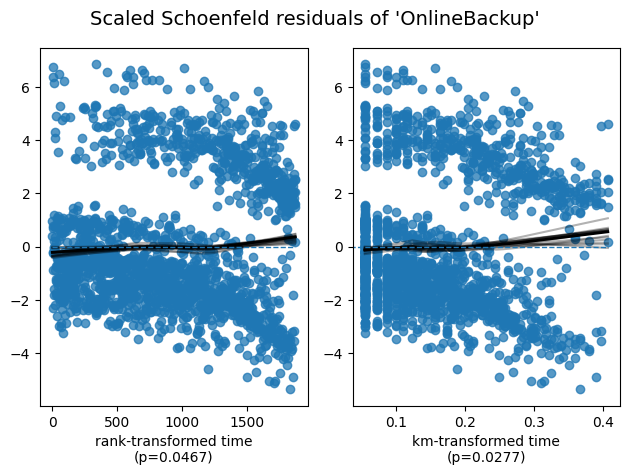

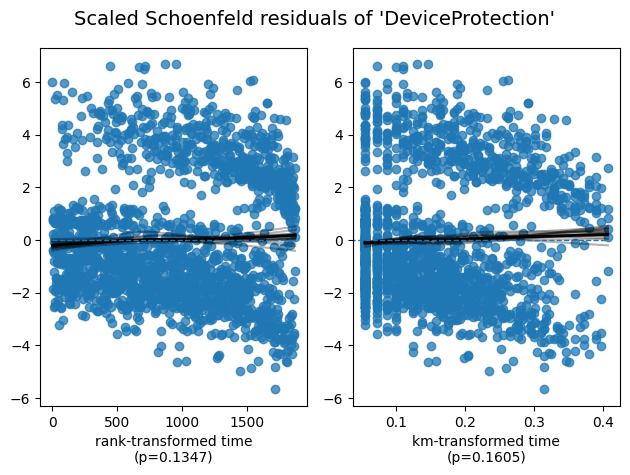

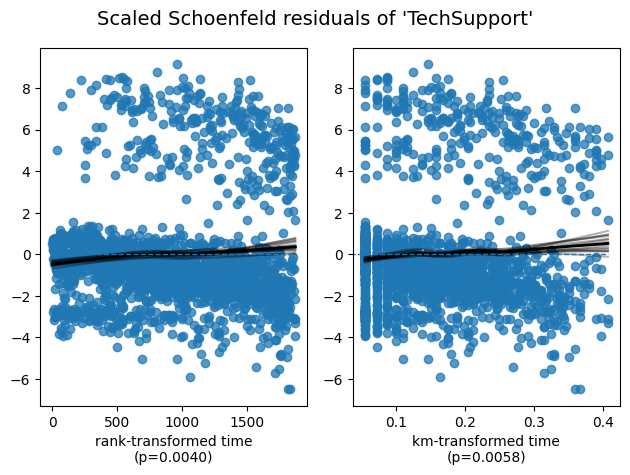

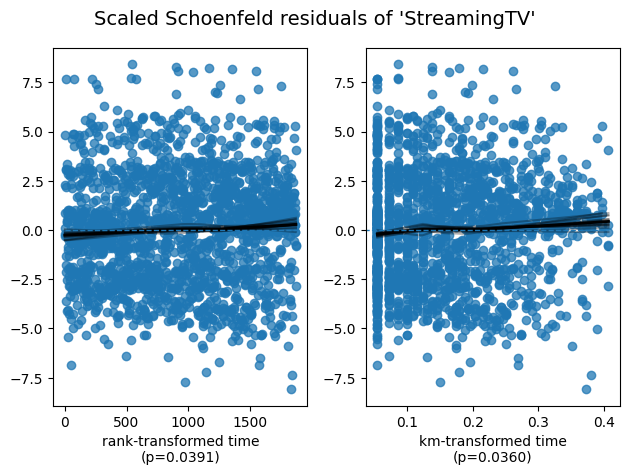

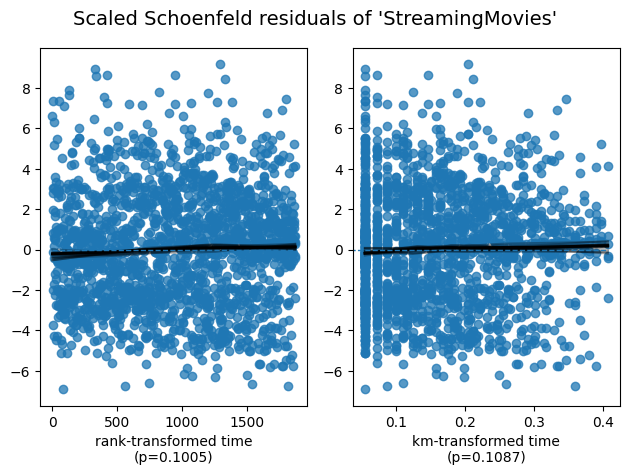

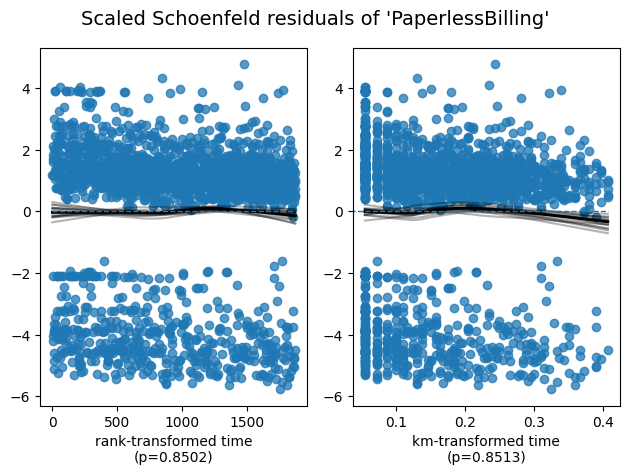

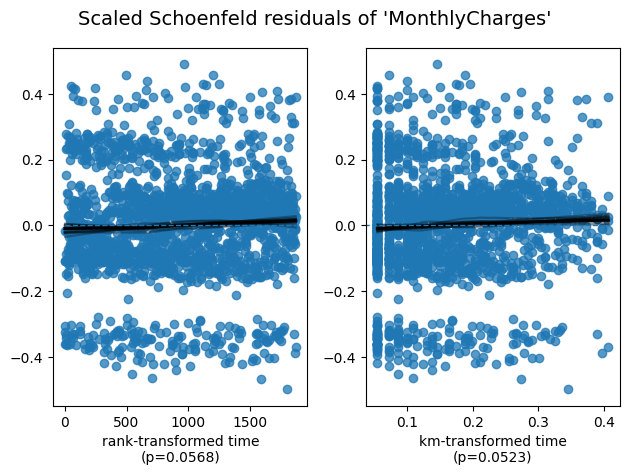

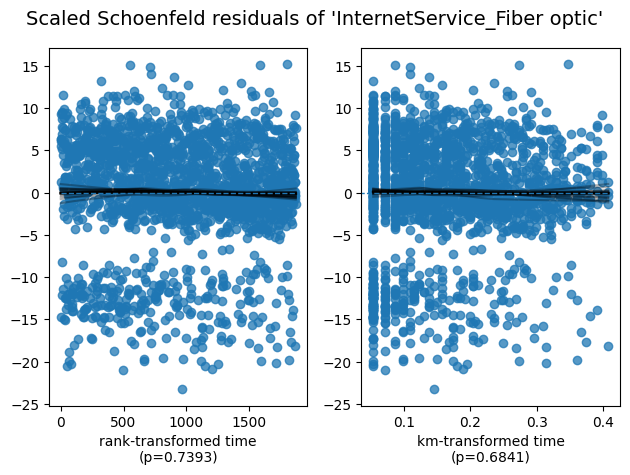

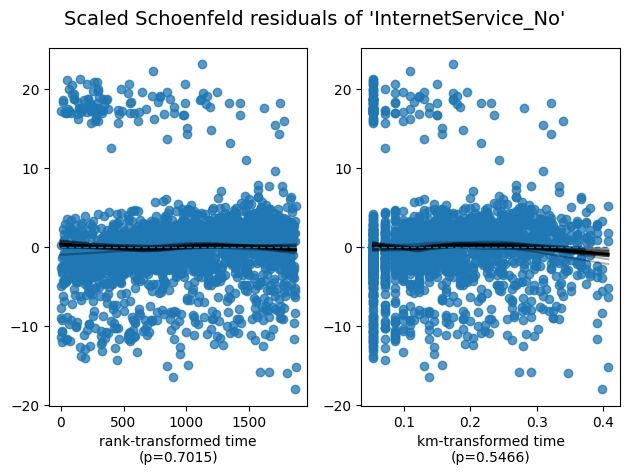

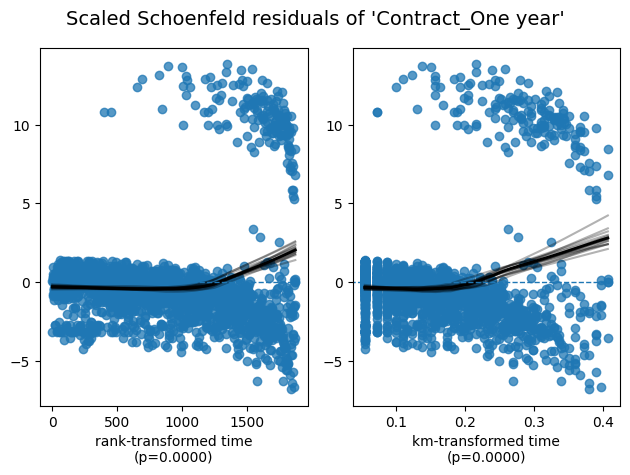

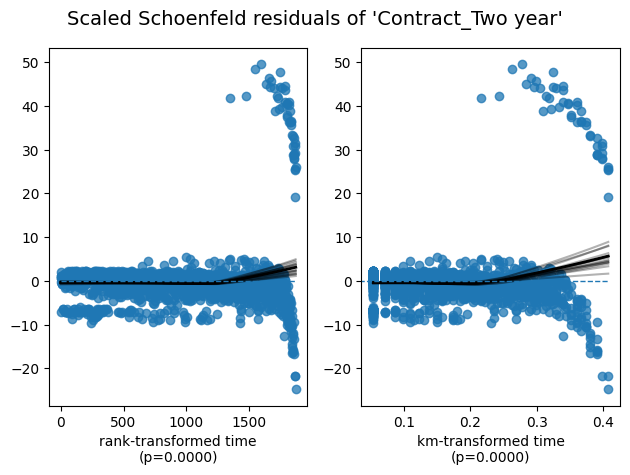

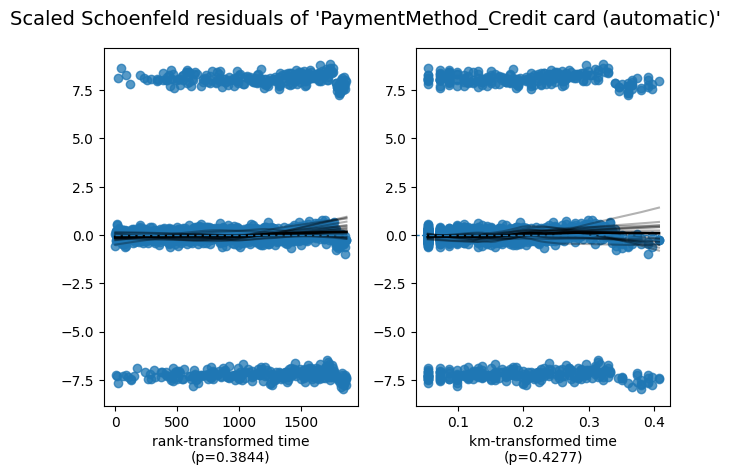

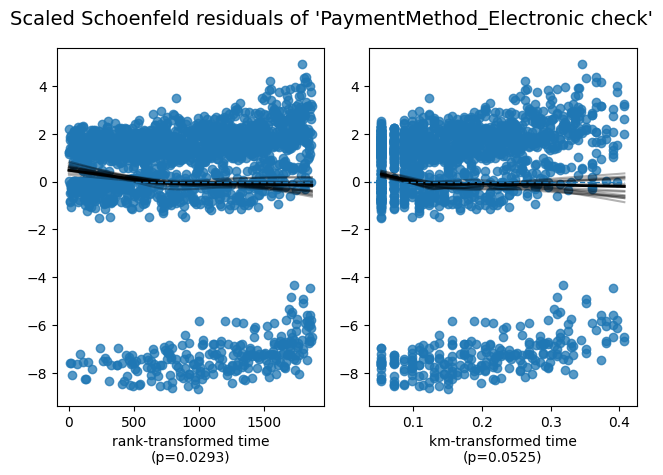

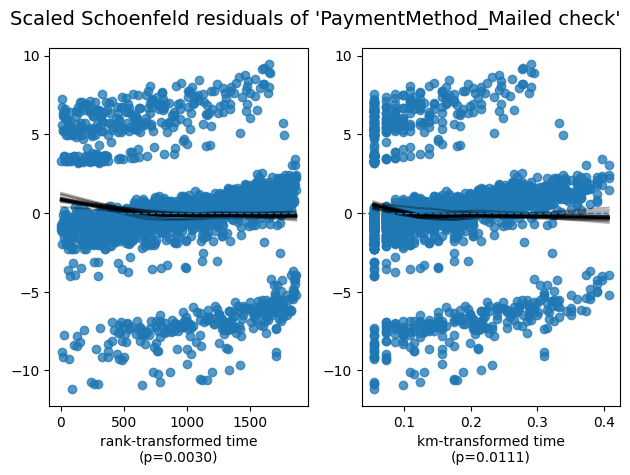

In [ ]:
# Check the Proportional Hazards Assumption to identify features violating the assumption.

# from lifelines.utils import check_assumptions

# Check proportional hazards assumption
cph.check_assumptions(training_df=churn_hazard_2, p_value_threshold=0.05, show_plots=True)

**Plot Layout:**

- Each subplot corresponds to a feature in the model.
- The x-axis represents time, either rank-transformed or Kaplan-Meier (KM)-transformed.
- The y-axis shows scaled Schoenfeld residuals, which measure deviations from the proportional hazards assumption over time.

**Key Features:**

- Line: The points on the plot (with possible smoothing or trends shown) represent the residuals for the feature across time.
- Confidence Bands (Black Region): The shaded region or band represents the expected variability if the proportional hazards assumption holds. Ideally, the residuals should lie within this region, showing no systematic trend.

**Interpretation:**

- No Systematic Trend: If the residuals appear randomly scattered without a systematic pattern and mostly stay within the confidence bands, the feature adheres to the proportional hazards assumption.
- Systematic Trend: If there’s a clear upward or downward trend in the residuals, or if many points fall outside the confidence bands, the feature violates the proportional hazards assumption. This suggests the effect of the feature on the hazard is not constant over time.
- P-values: Alongside the plots, p-values for the KM and rank tests are reported. A p-value below the threshold (commonly 0.05) indicates a significant violation of the proportional hazards assumption for that feature.

**Actionable Insights:**

- Features with significant p-values or strong visual deviations may need adjustment.
- Options include stratifying on the feature, introducing interaction terms with time, or reconsidering its inclusion in the model.

##### Note from official lifelines documentation:

- If your goal is survival prediction, then you don’t need to care about proportional hazards. Your goal is to maximize some score, irrelevant of how predictions are generated.

- Given a large enough sample size, even very small violations of proportional hazards will show up.

- There are legitimate reasons to assume that all datasets will violate the proportional hazards assumption. This is detailed well in Stensrud & Hernán’s “Why Test for Proportional Hazards?”.

- “Even if the hazards were not proportional, altering the model to fit a set of assumptions fundamentally changes the scientific question. As Tukey said,”Better an approximate answer to the exact question, rather than an exact answer to the approximate question.” If you were to fit the Cox model in the presence of non-proportional hazards, what is the net effect? Slightly less power. In fact, you can recover most of that power with robust standard errors (specify robust=True). In this case the interpretation of the (exponentiated) model coefficient is a time-weighted average of the hazard ratio–I do this every single time.” from AdamO, slightly modified to fit lifelines.

##### Fitting cox model on stratified features suggested in advice.

In [ ]:
strata_cols = ['OnlineBackup', 'OnlineSecurity', 'Partner']

cph = lifelines.CoxPHFitter()

cph.fit(churn_hazard_2, 'tenure', 'Churn',strata=strata_cols, show_progress=False)

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [ ]:
# Those customers who haven't churned are considered Right-Censored Observations.

churn_hazard_2.Churn.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [ ]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                   strata = ['OnlineBackup', 'OnlineSecurity', 'Partner']
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -11042.14
         time fit was run = 2025-02-23 16:18:23 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                         -0.11      0.90      0.06           -0.22            0.00                0.80                1.00
Dependents                            -0.04      0.96      0.07           -0.17            0.10                0.84                1.10
DeviceProtection                      -0.24      0.79      0.06           -0.35           -0.12                0.70                0.88
TechSupport                           -0.32      0.73      0.07           -0.45           -0.18                0.64                0.84
StreamingTV                            0.09      1.09      0.07           -0.04            0.22                0.96                1.24
StreamingMovies                        0.01      1.01      0.07           -0.13            0.14                0.88                1.15
PaperlessBilling                       0.15      1.17      0.06            0.04            0.27                1.04                1.30
MonthlyCharges                        -0.02      0.98      0.00           -0.02           -0.01                0.98                0.99
InternetService_Fiber optic            0.80      2.23      0.16            0.49            1.11                1.64                3.04
InternetService_No                    -1.36      0.26      0.13           -1.63           -1.10                0.20                0.33
Contract_One year                     -1.63      0.20      0.09           -1.81           -1.46                0.16                0.23
Contract_Two year                     -3.25      0.04      0.17           -3.58           -2.92                0.03                0.05
PaymentMethod_Credit card (automatic) -0.06      0.94      0.09           -0.24            0.11                0.78                1.12
PaymentMethod_Electronic check         0.59      1.80      0.07            0.45            0.73                1.56                2.07
PaymentMethod_Mailed check             0.60      1.83      0.09            0.43            0.78                1.54                2.18

                                       cmp to      z      p  -log2(p)
covariate                                                            
SeniorCitizen                            0.00  -1.91   0.06      4.15
Dependents                               0.00  -0.55   0.58      0.79
DeviceProtection                         0.00  -4.11 <0.005     14.60
TechSupport                              0.00  -4.53 <0.005     17.40
StreamingTV                              0.00   1.31   0.19      2.41
StreamingMovies                          0.00   0.08   0.94      0.09
PaperlessBilling                         0.00   2.72   0.01      7.25
MonthlyCharges                           0.00  -3.98 <0.005     13.80
InternetService_Fiber optic              0.00   5.10 <0.005     21.46
InternetService_No                       0.00 -10.17 <0.005     78.31
Contract_One year                        0.00 -18.21 <0.005    243.61
Contract_Two year                        0.00 -19.49 <0.005    278.54
PaymentMethod_Credit card (automatic)    0.00  -0.70   0.48      1.05
PaymentMethod_Electronic check           0.00   8.19 <0.005     51.79
PaymentMethod_Mailed check               0.00   6.81 <0.005     36.61
---
Concordance = 0.80
Partial AIC = 22114.27
log-likeliho

**Interpretation**

- The exp(coef) value for InternetService_Fiber optic reflects the hazard ratio relative to DSL.
- Similarly, the exp(coef) for InternetService_No reflects the hazard ratio relative to DSL.

Magnitude:

- HR > 1: The hazard increases for that category. For exp(coef) = 2.23, the hazard (likelihood of churn) is 2.23 times higher for customers with fiber-optic service compared to the reference group.
- HR = 1: No difference in hazard between the category and the reference.
- HR < 1: The hazard decreases for that category. For example, exp(coef) = 0.5 would mean a 50% lower hazard compared to the reference.

In [ ]:
cph.check_assumptions(training_df=churn_hazard_2, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
Contract_One year                     km             49.07 <0.005     38.56
                                      rank           10.22 <0.005      9.49
Contract_Two year                     km             28.56 <0.005     23.39
                                      rank            2.09   0.15      2.75
Dependents                            km              0.07   0.79      0.35
                                      rank            0.33   0.56      0.82
DeviceProtection                      km              2.40   0.12      3.04
                                      rank            0.64   0.42      1.24
InternetService_Fiber optic           km              0.27   0.60      0.74
                                      rank            1.35   0.25      2.03
InternetService_No                    km              0.00   0.99      0.01
                                      rank            1.18   0.28      1.85
MonthlyCharges                        km              3.78   0.05      4.27
                                      rank            0.06   0.81      0.30
PaperlessBilling                      km              0.02   0.89      0.17
                                      rank            0.14   0.70      0.51
PaymentMethod_Credit card (automatic) km              0.70   0.40      1.32
                                      rank            3.44   0.06      3.97
PaymentMethod_Electronic check        km              3.54   0.06      4.06
                                      rank            1.96   0.16      2.63
PaymentMethod_Mailed check            km              5.77   0.02      5.94
                                      rank            0.16   0.69      0.54
SeniorCitizen                         km              0.06   0.81      0.30
                                      rank            0.29   0.59      0.77
StreamingMovies                       km              2.36   0.12      3.01
                                      rank            2.15   0.14      2.81
StreamingTV                           km              4.33   0.04      4.74
                                      rank            0.74   0.39      1.37
TechSupport                           km              5.71   0.02      5.89
                                      rank           10.91 <0.005     10.03



1. Variable 'TechSupport' failed the non-proportional test: p-value is 0.0010.

   Advice: with so few unique values (only 2), you can include `strata=['TechSupport', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'StreamingTV' failed the non-proportional test: p-value is 0.0374.

   Advice: with so few unique values (only 2), you can include `strata=['StreamingTV', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'MonthlyCharges' failed the non-proportional test: p-value is 0.0519.

   Advice 1: the functional form of the variable 'MonthlyCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'MonthlyCharges' using pd.cut, and then specify it in
`strata=['MonthlyCharges', ...]` in the call in `.fit`. See docu

[]

- Need more research into picking the right balance between fixing non-proportional hazards issue and prediction.

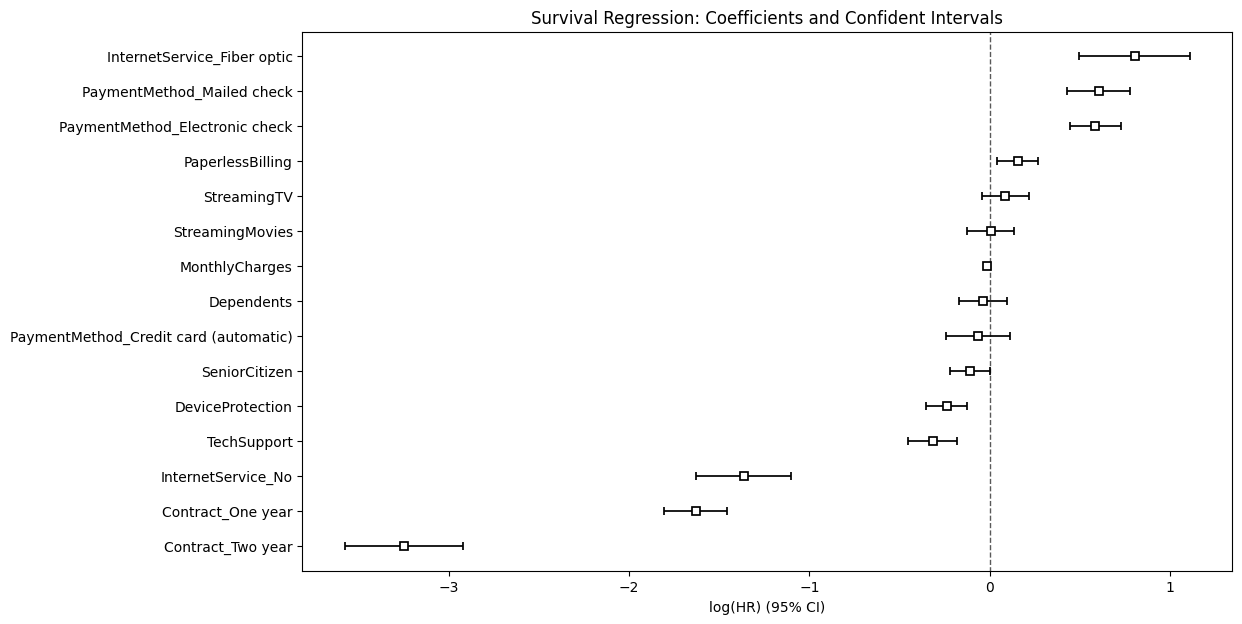

In [ ]:
# plotting coefficients

fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef);

**Positive Coefficients:**

- Covariates with coefficients greater than 0 indicate an increased hazard (higher risk of the event, e.g., churn) compared to the reference group.
The further the coefficient is from 0, the stronger the effect.

**Negative Coefficients:**

- Covariates with coefficients less than 0 indicate a decreased hazard (lower risk of the event, e.g., churn) compared to the reference group.

**Confidence Interval Crossing Zero:**

- If the confidence interval for a covariate crosses the vertical line at 0, it means the effect of that covariate is not statistically significant at the 95% confidence level.

**Confidence Interval Narrowness:**

- Narrow intervals indicate a precise estimate, while wide intervals suggest greater uncertainty.

**Example:**

- If MonthlyCharges has a positive coefficient and its CI does not cross zero:

    - This suggests that higher monthly charges are associated with an increased risk of churn.
The size of the coefficient indicates the strength of this relationship.

- Conversely, if a feature like Contract_Two_year has a negative coefficient:

    - This implies that customers on two-year contracts have a lower risk of churn compared to the reference contract type.

#### Cox PH approach 3

- Allowing lifelines package to encode categorical vars.

In [ ]:
churn_data

customerID  gender SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female            No     Yes         No       1   
1     5575-GNVDE    Male            No      No         No      34   
2     3668-QPYBK    Male            No      No         No       2   
3     7795-CFOCW    Male            No      No         No      45   
4     9237-HQITU  Female            No      No         No       2   
...          ...     ...           ...     ...        ...     ...   
7038  6840-RESVB    Male            No     Yes        Yes      24   
7039  2234-XADUH  Female            No     Yes        Yes      72   
7040  4801-JZAZL  Female            No     Yes        Yes      11   
7041  8361-LTMKD    Male           Yes     Yes         No       4   
7042  3186-AJIEK    Male            No      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95       1889.50   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80       1990.50   
7039              Yes    Credit card (automatic)         103.20       7362.90   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40        306.60   
7042              Yes  Bank transfer (automatic)         105.65       6844.50   

      Churn  
0        No  
1        No  
2       Yes  
3        No  
4       Yes  
...     ...  
7038     No  
7039     No  
7040     No  
7041    Yes  
7042     No  

[7043 rows x 21 columns]

In [ ]:
churn_data.TotalCharges.dtype

dtype('float64')

In [ ]:
churn_data.OnlineSecurity.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [ ]:
churn_hazard_3 = churn_data.drop(['TotalCharges'], axis=1).copy()

churn_hazard_3 = churn_hazard_3.set_index('customerID')

churn_hazard_3 = churn_hazard_3.applymap(lambda x: "No" if str(x).startswith("No ") else x)
churn_hazard_3['Churn'] = (churn_hazard_3['Churn'] == "Yes")
print(churn_hazard_3.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn'],
      dtype='object')


In [ ]:
churn_hazard_3.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
Churn                  bool
dtype: object

##### Pre-requisite EDA

In [ ]:
churn_hazard_3

In [ ]:
churn_hazard_3[strata_cols].head()

OnlineBackup OnlineSecurity Partner
customerID                                    
7590-VHVEG          Yes             No     Yes
5575-GNVDE           No            Yes      No
3668-QPYBK          Yes            Yes      No
7795-CFOCW           No            Yes      No
9237-HQITU           No             No      No

In [ ]:
churn_hazard_3[strata_cols].nunique()

OnlineBackup      2
OnlineSecurity    2
Partner           2
dtype: int64

In [ ]:
churn_hazard_3.OnlineSecurity.unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
pd.Series({c: churn_hazard_3[c].unique() for c in churn_hazard_3})

gender                                                 [Female, Male]
SeniorCitizen                                               [No, Yes]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
tenure              [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...
PhoneService                                                [No, Yes]
MultipleLines                                               [No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                                              [No, Yes]
OnlineBackup                                                [Yes, No]
DeviceProtection                                            [No, Yes]
TechSupport                                                 [No, Yes]
StreamingTV                                                 [No, Yes]
StreamingMovies                                             [No, Yes]
Contract                         [Month-to-month, One year, Two year]
PaperlessBilling                                            [Yes, No]
PaymentMethod       [Electronic check, Mailed check, Bank transfer...
MonthlyCharges      [29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...
Churn                                                   [False, True]
dtype: object

In [ ]:
churn_hazard_3.nunique()

In [ ]:
ch3_corr_data = churn_hazard_3[['gender','SeniorCitizen','Partner','Dependents','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges']].copy()

ch3_corr_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges'],
      dtype='object')

In [ ]:
pd.Series({c: ch3_corr_data[c].unique() for c in ch3_corr_data})

In [ ]:
binary_features = ['SeniorCitizen','Partner','Dependents','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','PaperlessBilling']

ch3_corr_data['gender'] = ch3_corr_data['gender'].map({'Male': 1, 'Female': 0})

for feat in binary_features:
    ch3_corr_data[feat] = (ch3_corr_data[feat] == 'Yes').astype(int)

# let's one hot encode the remaining categorical features
ohe_features = ['Contract', 'PaymentMethod']

ch3_corr_data = pd.get_dummies(ch3_corr_data,
                              drop_first=True,
                              columns=ohe_features,
                              dtype=int)

ch3_corr_data.dtypes

gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
MultipleLines                              int64
OnlineSecurity                             int64
OnlineBackup                               int64
DeviceProtection                           int64
TechSupport                                int64
PaperlessBilling                           int64
MonthlyCharges                           float64
Contract_One year                          int64
Contract_Two year                          int64
PaymentMethod_Credit card (automatic)      int64
PaymentMethod_Electronic check             int64
PaymentMethod_Mailed check                 int64
dtype: object

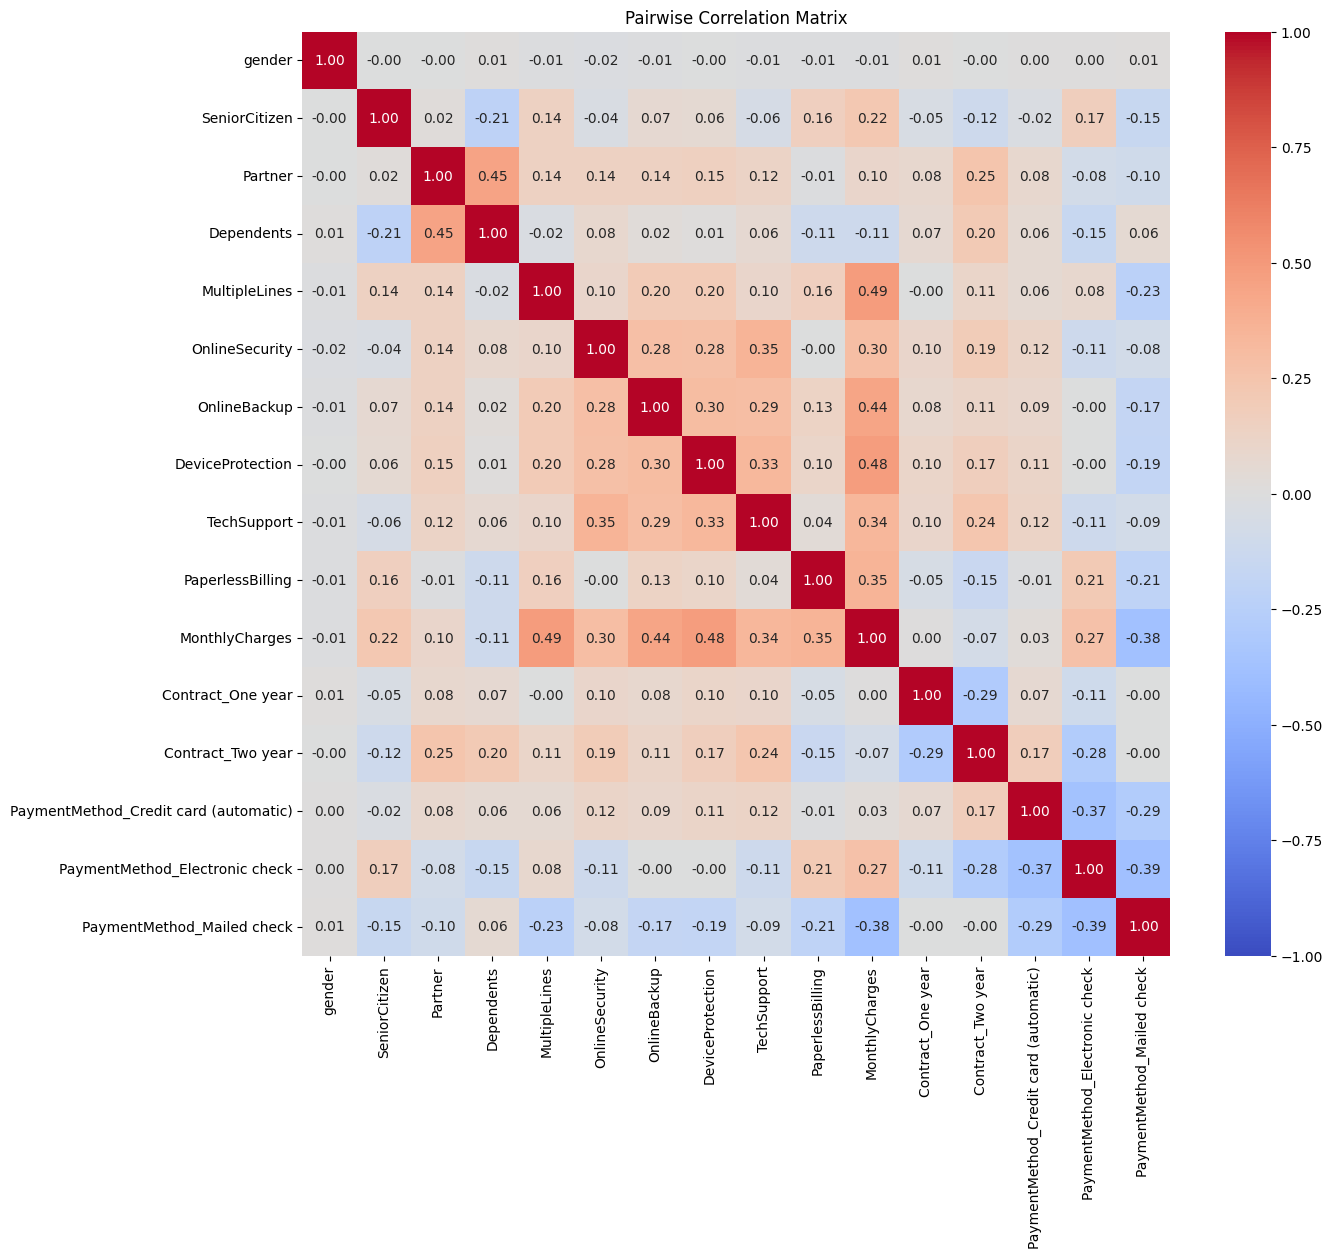

In [ ]:
corr_matrix = ch3_corr_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlation Matrix')
plt.show()

In [ ]:
# Looking at VIF for the columns

# Define the predictor variables
X = ch3_corr_data.copy()

# Add a constant to the model (intercept)
X = add_constant(X)

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

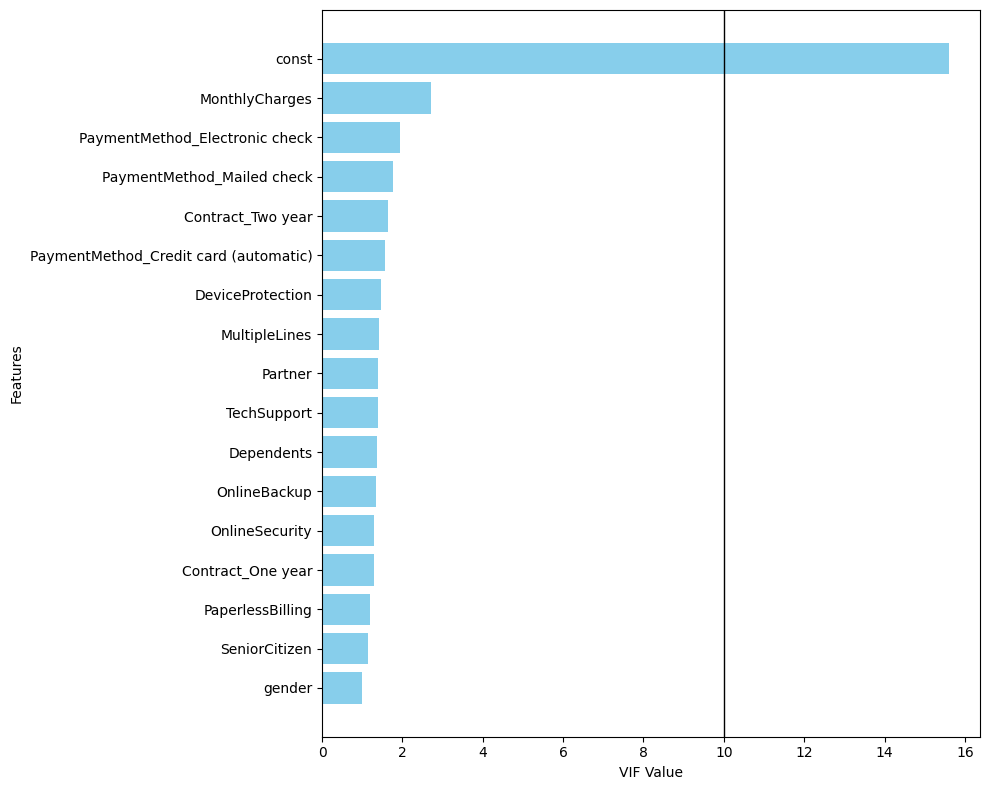

In [ ]:
# Replace infinite VIF values with a capped high value
vif_df['VIF'] = vif_df['VIF'].replace([np.inf, -np.inf], 100)

# Sort VIF values in descending order
vif_df = vif_df.sort_values(by='VIF', ascending=False)

# Plot the VIF values
plt.figure(figsize=(10, 8))
plt.barh(vif_df['Feature'], vif_df['VIF'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show highest VIF at the top
plt.xlabel('VIF Value')
plt.ylabel('Features')
plt.axvline(x=10, color='black', linewidth=1)
plt.tight_layout()
plt.show()

##### Fitting the CoxPH model

In [ ]:
from lifelines import CoxPHFitter

In [ ]:
churn_hazard_3.drop(['gender', 'PhoneService', 'MultipleLines'], axis = 1, inplace=True)

In [ ]:
strata_cols = ['InternetService', 'StreamingMovies', 'StreamingTV']

cph = CoxPHFitter().fit(churn_hazard_3, 'tenure', 'Churn',
                        formula="SeniorCitizen + Partner + Dependents + OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + Contract + PaperlessBilling + PaymentMethod + MonthlyCharges",
                        strata=strata_cols)

#### Kaplan-Meier curves for individual features.

In [ ]:
# function for creating Kaplan-Meier curve plots segmented
# by categorical variables
def plot_categorical_survival(feature, t='tenure', event='Churn', df=churn_data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

In [ ]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Contract', ax=ax_pmt)
ax_pmt.set_title('Customer Churn by Contract')
ax_pmt.set_xlabel('Customer Tenure (Months)')
ax_pmt.set_ylabel('Customer Survival Chance (%)')
plt.show()

- A steeper curve for Month-Month contract suggesting higher event rate (churn) happening in succession and close together.

- Two-Year contract has longer survival duration (longer horizontal line) indicating lower event frequency (lower churn)

- Month-Month also achieves median survival in approximately 30 months.(when half of the customers are expected to be churn)

In [ ]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='PaymentMethod', ax=ax_pmt)
ax_pmt.set_title('Customer Churn by Payment Method')
ax_pmt.set_xlabel('Customer Tenure (Months)')
ax_pmt.set_ylabel('Customer Survival Chance (%)')
plt.show()

In [ ]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='InternetService', ax=ax_pmt)
ax_pmt.set_title('Customer Churn by InternetService')
ax_pmt.set_xlabel('Customer Tenure (Months)')
ax_pmt.set_ylabel('Customer Survival Chance (%)')
plt.show()

#### Next Steps

* How to evaluate accuracy of this model?
* How to use this survival curve to predict probabilty of customer leaving after n months (ideally 3).